# Sparkify Project

## Table of Contents

<li><a href="#overview">Overview</a></li>
<li><a href="#imports">Imports</a></li>
<li><a href="#load_clean">Load and Clean Dataset</a></li>
    <ul>
    <li><a href="#load">Load the Dataset</a></li>
    <li><a href="#nulls">Search for null values</a></li>
    <li><a href="#clean">Clean the dataframes</a></li>
    </ul>
<li><a href="#eda">Exploratory Data Analysis</a></li>
    <ul>
    <li><a href="#preliminary">Preliminary Analysis</a></li>
    <li><a href="#churn">Define the Churn</a></li>
    <li><a href="#ed">Explore Data</a></li>
        <ul>
        <li><a href="#num_downgrades">Number of Downgrades per User</a></li>
        <li><a href="#level">Level of Each User</a></li>
        <li><a href="#platform">Platform</a></li>
        <li><a href="#days_activity">Days of Activity</a></li>
        <li><a href="#prop_pages">Proportion of Each Page by User</a></li>
        <li><a href="#mean_time_session">Mean Time per Session by User</a></li>
        <li><a href="#mean_songs_session">Mean Number of Songs per Session by User</a></li>
        <li><a href="#mean_sessions_week">Mean Number of Sessions per Week by User</a></li>
        <li><a href="#mean_time_week">Mean Time per Week by User</a></li>
        <li><a href="#prop_time_week_month">Proportion of Time in the Last Week Respect to the Last Month</a></li>
        <li><a href="#prop_songs_week_month">Proportion of Songs in the Last Week Respect to the Last Month</a></li>
        <li><a href="#mean_artists_week">Mean Number of Different Artists per Week</a></li>
        <li><a href="#total_artists">Total Number of Different Artists</a></li>
        </ul>
     </ul>
<li><a href="#feat_eng">Feature Engineering</a></li>
<li><a href="#modeling">Modeling</a></li>
<li><a href="#conclusions">Conclusions</a></li>


<a id='overview'></a>
## Overview

In this project we are going to work with data that belongs to a ficticial company, Sparkify. This company, like Spotify offers a service of music online. We have a file of 128MB that contains information about the users and their activity in the service that is part of a bigger dataset of data of 12GB.

The objective of this project is to try to make predictions about the `churn` of the company. Especifically we are interested in making predictions about whether a customer is going to leave the service or not.

The data contained in the file is like a log of actions of the users. It is registered each time a user click on a page or option. The differente options that we can find on the log are these ones:

    - Cancel                         - Cancellation Confirmation
    - Submit Downgrade               - Submit Upgrade
    - Error                          - Save Settings
    - About                          - Upgrade
    - Help                           - Settings
    - Downgrade                      - Thumbs Down
    - Logout                         - Roll Advert
    - Add Friend                     - Add to Playlist
    - Home                           - Thumbs Up
    - NextSong
    
In the inputs is also saved information about the songs (the lenght, the name, the artist...), about the users (the name, the gender, level, location, register date ...)

We have to assess all this information, clean it, extract useful features and perform a modeling with Machine Learning to try to identify those customers that are likely that cancel their account.

After the evaluation of the dataset we have gathered a list of possible features:

**Numerical Features**
    - number of downgraes by user (Integer)
    - days of activity (Integer)
    - proportion of each type of page (Float between 0 and 1)
    - mean time in minutes per session (Float)
    - mean number of songs per session (Float)
    - mean number of sessions by week (Float)
    - mean time of use in minutes by week (Float)
    - relation between the time of use by day in the last week compared
      with the time of use by day of the last month (Float)
    - proportion of the number of songs in the last week compared
      with the number of songs of the last month. (Float between 0 and 1)
    - proportion of the number of different artists listened in the last week compared
      with the different artists in the last month. (Float between 0 and 1)
    - total number of different artists (Integer)


**Categorical Features**
    - gender
    - level (free or paid)
    - platform (os and device used to access to the service)



Finally we have used these features to train some Machine Learnig Models:

    - Logistic Regression
    - Weighted Logistic Regression
    - Decision Trees Classifier
    - Random Forest Classifier
    - GBT Classifier
    - Weighted Linear SVC


A blog with the summary of this work was posted in this [link](https://medium.com/@jesus.mira74/sparkify-analysis-of-churn-predictions-using-pyspark-f6a6a12530ae)

Let's start with the analysis.

<a id='imports'></a>
## Imports

Firstly we are going to do the necessary imports,

In [1]:
# import libraries
import numpy as np
import pandas as pd
import json
import re
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from functools import reduce
from operator import add
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql.functions import isnull, udf, split, regexp_replace,col, concat
from pyspark.sql.functions import lit, hour, month, year, dayofmonth, weekofyear
from pyspark.sql.functions import date_format, concat_ws, row_number, when, datediff, mean, count
from pyspark.sql.functions import desc, asc, first, last , col, rand, log10
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import min as Fmin
from pyspark.sql.types import IntegerType, StringType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import DenseVector, SparseVector, Vectors, VectorUDT

%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

sns.set_context("talk")

In [2]:
# code to start a session in the IBM Watson Studio platform
'''
## crate a Spark Session in IBM Watson Studio
import ibmos2spark
## @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'xxxxxx',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'xxxxxxxx'
}

configuration_name = 'xxxxxx'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

'''

"\n## crate a Spark Session in IBM Watson Studio\nimport ibmos2spark\n## @hidden_cell\ncredentials = {\n    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',\n    'service_id': 'xxxxxx',\n    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',\n    'api_key': 'xxxxxxxx'\n}\n\nconfiguration_name = 'xxxxxx'\ncos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')\n\nfrom pyspark.sql import SparkSession\nspark = SparkSession.builder.getOrCreate()\n\n# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.\n# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.\n# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json\n\n"

In [3]:
# create a Spark session in local
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

<a id='load_clean'></a>
## Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. We need to clean the dataset and check for invalid or missing data - for example, records without userids or sessionids. 

<a id='load'></a>
### Load the Dataset

In [4]:
# Load the DataFrame in IBM Watson Studio
'''
df = spark.read.json(cos.url('mini_sparkify_event_data.json', 'sparkify-donotdelete-pr-le5hfmtpznpydh'))
df.take(1)
'''

"\ndf = spark.read.json(cos.url('mini_sparkify_event_data.json', 'sparkify-donotdelete-pr-le5hfmtpznpydh'))\ndf.take(1)\n"

In [5]:
# load the spark Dataframe
df = spark.read.json('mini_sparkify_event_data.json')
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [6]:
# take a look of the schema of the dataframe
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.count()

286500

It contains 286500 rows.

<a id='nulls'></a>
### Search for null values

In [8]:
 # define a panda's dataframe with the number of null of each column
nulls = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]) \
          .toPandas() \
          .T \
          .rename(columns={0: "nulls"}) \
          .sort_values(by=['nulls'], 
                       ascending=False)

In [9]:
nulls

,nulls
artist,58392
length,58392
song,58392
firstName,8346
gender,8346
userAgent,8346
lastName,8346
location,8346
registration,8346
sessionId,0


In [10]:
df.filter(isnull(df['song'])).toPandas()['page'].unique()

array(['Add to Playlist', 'Roll Advert', 'Thumbs Up', 'Downgrade',
       'Thumbs Down', 'Home', 'Logout', 'Help', 'Login', 'Upgrade',
       'Add Friend', 'About', 'Settings', 'Submit Upgrade',
       'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
       'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object)

In [11]:
df.filter(isnull(df['gender'])).toPandas()['page'].unique()

array(['Home', 'Help', 'Login', 'About', 'Error', 'Register',
       'Submit Registration'], dtype=object)

We have some rows with null values, but it seems that they can be normal. We have 58392 rows without information about songs, but this happens in pages where this data is not necessary. There are not also information about the user in those pages previous to the register or login page.

We are going to search also for empty strings:

In [12]:
 # define a panda's dataframe with the number of empty strings of each column
empty_strings = df.select([count(when(df[c]=='', c)).alias(c) for c in df.columns]) \
          .toPandas() \
          .T \
          .rename(columns={0: "nulls"}) \
          .sort_values(by=['nulls'], 
                       ascending=False)

In [13]:
empty_strings

,nulls
userId,8346
auth,0
userAgent,0
ts,0
status,0
song,0
sessionId,0
registration,0
page,0
artist,0


The only column with empty strings is userID. This column is fundamental because it is going to be the base of our analysis to differentiate the users.

In [14]:
df.filter(isnull(df['userId']) | (df['userId']=='')).toPandas()['page'].unique()

array(['Home', 'Help', 'Login', 'About', 'Error', 'Register',
       'Submit Registration'], dtype=object)

We can see againg that we don't have information about the user on those pages previous to the register or login, which is normal. 

In [15]:
df.filter(isnull(df['song']) | (df['song']=='')).toPandas()['page'].unique()

array(['Add to Playlist', 'Roll Advert', 'Thumbs Up', 'Downgrade',
       'Thumbs Down', 'Home', 'Logout', 'Help', 'Login', 'Upgrade',
       'Add Friend', 'About', 'Settings', 'Submit Upgrade',
       'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
       'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object)

In [16]:
df.filter(~isnull(df['song']) & (df['song']!='')).toPandas()['page'].unique()

array(['NextSong'], dtype=object)

The only page where we have information about the song is `NextSong`, which is not a surprise also.

In [17]:
df.describe('length').show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



And in the previous table we can see the basic statistics for the length of the songs, the mean lenght is about 4 minutes.

In [18]:

df.select("status").dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



It seems that the column status makes reference to the HTTP response (200: OK, 404: Not Found and 307: Redirect) )

In [19]:
df.filter((df['page']=='Error')).select('status').dropDuplicates().show()

+------+
|status|
+------+
|   404|
+------+



In [20]:
df.select('method').dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



<a id='clean'></a>
### Clean the dataframe

* The first thing we are going to do is to delete all the rows with an empty `userId` because they are useless for our analysis.

In [21]:
df_new = df.filter(df['userId']!='')

* Now we are going to remove all the special characters in the dataset.

In [22]:
# remove any special character into the dataset
for field in ['firstName', 'lastName', 'song', 'artist']:
    df_new = df_new.withColumn(field, regexp_replace(field, '[^a-zA-Z0-9\,\-]', ''))
    

* We are going to format the datetime data contained in the columns `ts` and `registration` to asses the behavior of the customers by hour or day.

In [23]:
# udf function used to format timestamp
format_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d %H:%M:%S'))

# new column 'event_time' with 'ts' in date time format
df_new = df_new.withColumn('event_time', format_time(df_new.ts))

# new column 'reg_time' with 'registration' in date time format
df_new = df_new.withColumn('reg_time', format_time(df_new.registration))

In [24]:
df_new.select(['event_time', 'reg_time']).show(3)

+-------------------+-------------------+
|         event_time|           reg_time|
+-------------------+-------------------+
|2018-10-01 00:01:57|2018-09-28 22:22:42|
|2018-10-01 00:03:00|2018-09-30 18:20:30|
|2018-10-01 00:06:34|2018-09-28 22:22:42|
+-------------------+-------------------+
only showing top 3 rows



In [25]:
df_new.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, event_time: string, reg_time: string]

<a id='eda'></a>
## Exploratory Data Analysis

We are going to perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

<a id='preliminary'></a>
### Preliminary Analysis

* How many rows do we have in the cleaned dataset?

In [26]:
df_new.count()

278154

* How many users are there in the dataset?

In [27]:
df_new.select(['userId']).dropDuplicates(['userId']).count()

225

* How many users do we have by gender?

In [28]:
df_new.select(['userId', 'gender']).dropDuplicates(['userId']).groupby(['gender']).count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



* How many users do we have by level?

In [29]:
df_new.select(['userId', 'level']). \
       dropDuplicates(['userId', 'level']). \
       groupby(['level']).count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|  195|
| paid|  165|
+-----+-----+



In [30]:
df_new.select(['userId', 'level']) \
       .dropDuplicates(['userId', 'level']) \
       .groupby(['userId']) \
       .agg(count('level').alias('cnt')).where(col('cnt')  > 1).count()


135

It seems that 135 users appear in both levels.

* How many users there are by gender and level?

In [31]:
df_new.select(['userId', 'level', 'gender']). \
       dropDuplicates(['userId', 'level']). \
       groupby(['level', 'gender']).count().show()

+-----+------+-----+
|level|gender|count|
+-----+------+-----+
| free|     M|  106|
| paid|     M|   86|
| paid|     F|   79|
| free|     F|   89|
+-----+------+-----+



* How many differente locations do we have?

In [32]:
df_new.select("location").dropDuplicates().sort("location").take(10)

[Row(location='Albany, OR'),
 Row(location='Albany-Schenectady-Troy, NY'),
 Row(location='Alexandria, LA'),
 Row(location='Allentown-Bethlehem-Easton, PA-NJ'),
 Row(location='Anchorage, AK'),
 Row(location='Atlanta-Sandy Springs-Roswell, GA'),
 Row(location='Atlantic City-Hammonton, NJ'),
 Row(location='Austin-Round Rock, TX'),
 Row(location='Bakersfield, CA'),
 Row(location='Baltimore-Columbia-Towson, MD')]

In [33]:
df_new.select("location").dropDuplicates().sort("location").count()

114

* How many times the users has entered on each page?

In [34]:
df_new.select('page','UserId'). \
       groupby('page').agg({'page':'count'}). \
       select('page','count(page)'). \
       sort("count(page)").show()


+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|         52|
|Cancellation Conf...|         52|
|    Submit Downgrade|         63|
|      Submit Upgrade|        159|
|               Error|        252|
|       Save Settings|        310|
|               About|        495|
|             Upgrade|        499|
|                Help|       1454|
|            Settings|       1514|
|           Downgrade|       2055|
|         Thumbs Down|       2546|
|              Logout|       3226|
|         Roll Advert|       3933|
|          Add Friend|       4277|
|     Add to Playlist|       6526|
|                Home|      10082|
|           Thumbs Up|      12551|
|            NextSong|     228108|
+--------------------+-----------+



It seems that there have been 52 cancelations, and the page most visited is obviously `NextSong`.

* We can also take a look of the behavior of the customers by hour or by day of the week. For example we can see if it is more likely to have a cencellation at some hour of day. This kind of information may not be useful for making predictions, but if we are thinking in launching a campaing, it can indicate us the best day or the best hour to do it.

In [35]:
df_new = df_new.withColumn('hour', hour(df_new.event_time))

In [36]:
cancel_in_hour = df_new.filter(df_new.page == "Cancel"). \
                       groupby(df_new.hour).count(). \
                       orderBy(df_new.hour.cast("float")).toPandas()

sub_down_in_hour = df_new.filter(df_new.page == "Submit Downgrade"). \
                       groupby(df_new.hour).count(). \
                       orderBy(df_new.hour.cast("float")).toPandas()

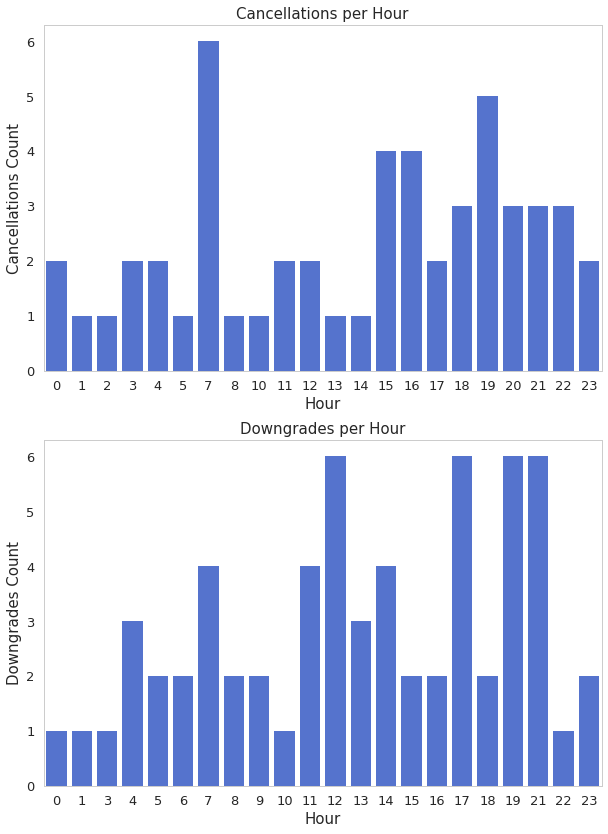

In [37]:
plt.figure(figsize=(10,14))

plt.subplot(2, 1, 1)
ax = sns.barplot(x='hour', y='count', data=cancel_in_hour, color = 'royalblue')
ax.set_title("Cancellations per Hour", fontsize=15)
ax.set_xlabel("Hour", fontsize=15)
ax.set_ylabel("Cancellations Count", fontsize=15)

plt.subplot(2, 1, 2)
ax = sns.barplot(x='hour', y='count', data=sub_down_in_hour, color = 'royalblue')
ax.set_title("Downgrades per Hour", fontsize=15)
ax.set_xlabel("Hour", fontsize=15)
ax.set_ylabel("Downgrades Count", fontsize=15);


In general there are more cancellations in the afternoon, but we have had a peak of cancellations at 7 in the morning.

* In this dataset we only have information of two months, but we can explore anyway in which one there have been more cancellations.

In [38]:
df_new = df_new.withColumn('month', month(df_new.event_time))

In [39]:
cancel_in_month = df_new.filter(df_new.page == "Cancel"). \
                        groupby(df_new.month).count(). \
                        orderBy(df_new.month.cast("float")).toPandas()

sub_down_in_month = df_new.filter(df_new.page == "Submit Downgrade"). \
                       groupby(df_new.month).count(). \
                       orderBy(df_new.month.cast("float")).toPandas()

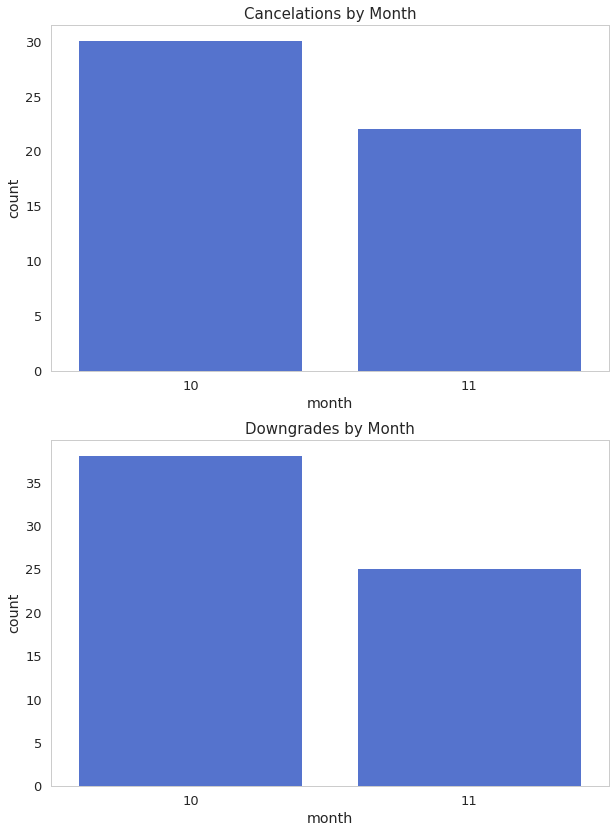

In [40]:
plt.figure(figsize=(10,14))

plt.subplot(2, 1, 1)
ax = sns.barplot(x='month', y='count', data=cancel_in_month, color = 'royalblue')
ax.set_title("Cancelations by Month", fontsize=15)

plt.subplot(2, 1, 2)
ax = sns.barplot(x='month', y='count', data=sub_down_in_month, color = 'royalblue')
ax.set_title("Downgrades by Month", fontsize=15);

There were more accounts cancelled and downgraded in Octover than in November.

* Let's continue with the analysis of the cancellations, but in this occasion by day of the week.

In [41]:
# add columns with the day of the week, numerical and string
df_new = df_new.withColumn('dow_number', date_format('event_time', 'u'))
df_new = df_new.withColumn('dow_string', date_format('event_time', 'E'))

In [42]:
cancel_in_dow = df_new.filter(df_new.page == "Cancel"). \
                        groupby([df_new.dow_string, df_new.dow_number]).count(). \
                        orderBy(df_new.dow_number).toPandas()

sub_down_in_month = df_new.filter(df_new.page == "Submit Downgrade"). \
                        groupby([df_new.dow_string, df_new.dow_number]).count(). \
                        orderBy(df_new.dow_number).toPandas()

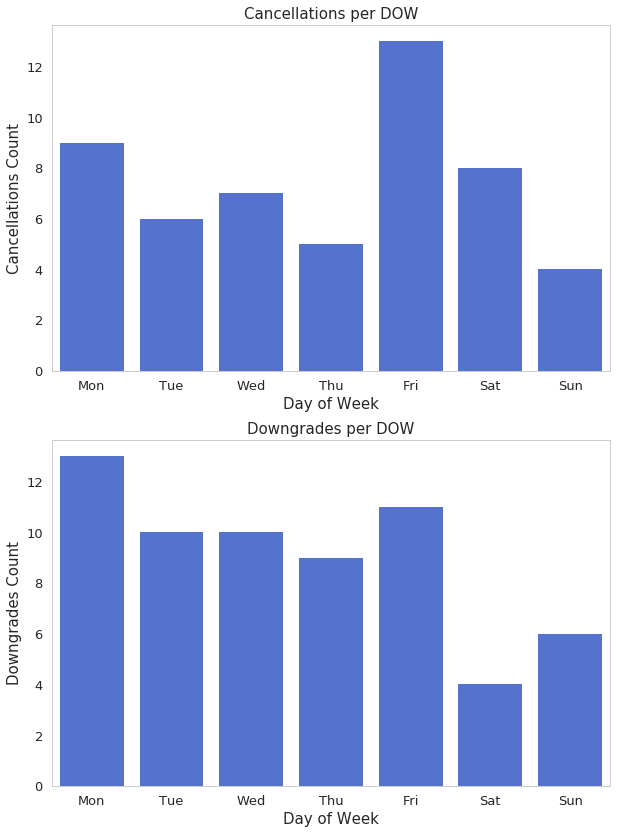

In [43]:
plt.figure(figsize=(10,14))
plt.subplot(2, 1, 1)
ax = sns.barplot(x='dow_string', y='count', data=cancel_in_dow, color = 'royalblue')
ax.set_title("Cancellations per DOW", fontsize=15)
ax.set_xlabel("Day of Week", fontsize=15);
ax.set_ylabel("Cancellations Count", fontsize=15)

plt.subplot(2, 1, 2)
ax = sns.barplot(x='dow_string', y='count', data=sub_down_in_month, color = 'royalblue')
ax.set_title("Downgrades per DOW", fontsize=15)
ax.set_xlabel("Day of Week", fontsize=15);
ax.set_ylabel("Downgrades Count", fontsize=15);

We surely don't have enough data in this dataset to be sure of this, but it seems that there are more cancellations on Friday, while the downgrades are in general distributed along Mondays to Fridays.

<a id='churn'></a>
### Define the Churn

In our case we are going to identify the churn as those clients that cancel their account. We are going to try to predict if a customer has cancelled its account or not. To do this we only have to identify those customers with a `Cancellation Confirmation` message in their history.

The `Submit Downgrade` could be also considered, we are going to count the downgrades by user also but it is not going to be used to define the `churn`, instead of that we are going to use it as a feature.

In [44]:
# udf to check if a page is a 'Cancellation Confirmation' or not.
flag_cancel_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

In [45]:
# add a column with 1's in the 'Cancellation Confirmation' messages and 0 otherwise
df_new = df_new.withColumn('canceled', flag_cancel_event('page'))

In [46]:
# define a window partitioning by `userId`
windowval = Window.partitionBy('userId').orderBy(desc('ts')) \
                  .rangeBetween(Window.unboundedPreceding, 0)

In [47]:
# add a new column with a 0 in all the messages of a user if they have not cacelled their account
# and add 1 each time they cancelled the account
df_new = df_new.withColumn('phase_cancel', Fsum('canceled').over(windowval))

In [48]:
df_new.select(['userId', 'phase_cancel']) \
       .dropDuplicates().show(5)

+------+------------+
|userId|phase_cancel|
+------+------------+
|100010|           0|
|200002|           0|
|   125|           1|
|   124|           0|
|    51|           1|
+------+------------+
only showing top 5 rows



In [49]:
df_new.select(['phase_cancel']) \
      .dropDuplicates().show()

+------------+
|phase_cancel|
+------------+
|           0|
|           1|
+------------+



No user has cancelled his account twice, but we are not sure of whether this could occur with more data, probably their userID will be different if they register again. To define the `churn` we will create a column based in the column `phase_cancel`, if a user has the value 0 the churn will be 0 also, and it will be 1 otherwise, even if the number of cancellations is bigger than 1.

In [50]:
# udf_function to define the churn_label column
udf_churn = udf(lambda x: 0 if x == 0 else 1, IntegerType())

# add a new column with the churn label
df_new = df_new.withColumn('churn_label', udf_churn('phase_cancel'))

In [51]:
df_new.select(['userId', 'churn_label']) \
      .dropDuplicates() \
      .groupby(['churn_label']).count().show()

+-----------+-----+
|churn_label|count|
+-----------+-----+
|          1|   52|
|          0|  173|
+-----------+-----+



There are 52 users with the 'churn_label' equal to 1 and 173 that have not perform any cancellation.

<a id='ed'></a>
### Explore the Data

In this part a deeper analysis will be performed. We are going to create new dataframes with possible features that will be used later in the modeling.

<a id='num_dowgrades'></a>
#### Number of Downgrades per User

We are interested in knowing the number of downgrades of each user. To do this we are going to apply a procedure similar to what we used to compute the churn.

In [52]:
# udf to check if a page is a 'Submit Downgrade' or not.
flag_downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
# add a column that incremets its value by 1 each time a user perform a downgrade
df_new = df_new.withColumn('downgraded', flag_downgrade_event('page'))
df_new = df_new.withColumn('phase_downgrade', Fsum('downgraded').over(windowval))

In [53]:
df_new.select(['userId', 'phase_cancel', 'phase_downgrade']) \
       .dropDuplicates() \
       .groupby(['phase_cancel', 'phase_downgrade']) \
       .count().show()

+------------+---------------+-----+
|phase_cancel|phase_downgrade|count|
+------------+---------------+-----+
|           1|              0|   52|
|           1|              1|    9|
|           0|              1|   40|
|           0|              3|    2|
|           0|              0|  173|
|           0|              2|   12|
+------------+---------------+-----+



It seems that only 9 of 52 users have performed a downgraded before they have cencelled their account.
In total 40 users have downgraded the account at least once, 2 of them have executed until 3 downgrades, but they don't have cancelled the account.

To be used as a feture we will create a dataframe with the number of downgrades performed by each user.

In [54]:
# define a datafrmae with the maximum number of downgrades by user.
df_downgrades = df_new.select(['userId', 'phase_downgrade']) \
                      .groupby(['userId']) \
                      .agg({'phase_downgrade' : 'max'}) \
                      .withColumnRenamed('max(phase_downgrade)', 'num_downgrades')

df_downgrades.show(5)

+------+--------------+
|userId|num_downgrades|
+------+--------------+
|100010|             0|
|200002|             0|
|   125|             0|
|   124|             0|
|    51|             0|
+------+--------------+
only showing top 5 rows



<a id='level'></a>
#### Level of Each User

We have seen that one user can have periods of time with the two levels: free and paid. We are going to consider only the level in the time of the cancellation or in the most recent time, since we have already taken into account the number of downgrades before.

In [55]:
window = Window.partitionBy('userId').orderBy(col('ts').desc())

df_level = df_new.select(['userId', 'phase_cancel', 'level', 'ts']) \
                 .select('*', row_number().over(window).alias('row_num')) \
                 .where(col('row_num') == 1) \
                 .select(['userId', 'phase_cancel', 'level'])

df_level.show(5)

+------+------------+-----+
|userId|phase_cancel|level|
+------+------------+-----+
|100010|           0| free|
|200002|           0| paid|
|   125|           1| free|
|   124|           0| paid|
|    51|           1| paid|
+------+------------+-----+
only showing top 5 rows



In [56]:
df_aux = df_level.toPandas()

In [57]:
df_aux = df_aux.groupby(['phase_cancel','level'])['userId'].agg(['count']).reset_index()

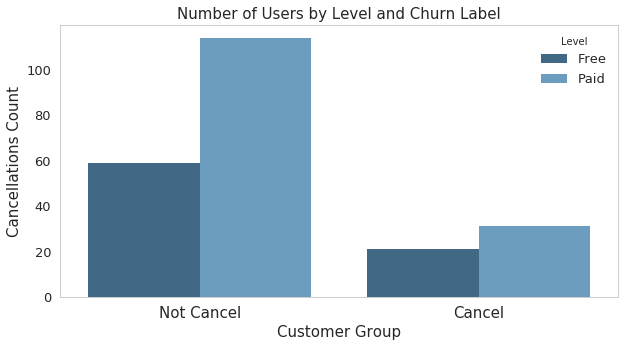

In [58]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='phase_cancel', y='count', hue = 'level', data=df_aux, palette = 'Blues_d')
ax.set_title("Number of Users by Level and Churn Label", fontsize=15)
ax.set_xticklabels(['Not Cancel', 'Cancel'], fontsize=15)
ax.set_xlabel('Customer Group', fontsize=15)
ax.set_ylabel('Cancellations Count', fontsize=15)
# replace labels on legend
legend = ax.legend()
legend.set_title("Level")
for t, l in zip(legend.texts,("Free", "Paid")):
    t.set_text(l)

The customers that have not cancelled their account have a bigger proportion of paid users.

<a id='platform'></a>
#### Platform

Let's see if we can extract the platform that they used to connect to the service.

In [59]:
# regular expresion to extract text between parenthesis
regex_par = '\(([^\)]*)\)'
# regular expression to identify semicolons
regex_semicolon = '\;'

In [60]:
# extract the platform (Windows, Linux, Mac, etc) for each user
df_platform = df_new.select(['userId', 'phase_cancel', 'userAgent']) \
                    .dropDuplicates(['userId', 'phase_cancel', 'userAgent']) \
                    .withColumn('platform', F.regexp_extract('userAgent', regex_par, idx=1))
df_platform = df_platform.withColumn('platform', F.split('platform', regex_semicolon).getItem(0)) \
                         .select(['userId', 'phase_cancel', 'platform'])

In [61]:
df_platform.show(5)

+------+------------+--------------+
|userId|phase_cancel|      platform|
+------+------------+--------------+
|100010|           0|        iPhone|
|200002|           0|        iPhone|
|   125|           1|     Macintosh|
|   124|           0|     Macintosh|
|    51|           1|Windows NT 6.1|
+------+------------+--------------+
only showing top 5 rows



In [62]:
# count the number o users per platform 
df_platform_count = df_platform.groupBy(['platform', 'phase_cancel']) \
                               .agg({'userId' : 'count'}) \
                               .withColumnRenamed('count(userId)', 'platform_count')

In [63]:
df_aux = df_platform_count.toPandas()

In [64]:
df_aux.sort_values(by=['platform', 'phase_cancel']).head(20)

,platform,phase_cancel,platform_count
8,Macintosh,0,67
9,Macintosh,1,19
4,Windows NT 5.1,0,4
0,Windows NT 5.1,1,1
1,Windows NT 6.0,0,1
13,Windows NT 6.1,0,63
2,Windows NT 6.1,1,17
14,Windows NT 6.2,0,3
6,Windows NT 6.2,1,1
3,Windows NT 6.3,0,11


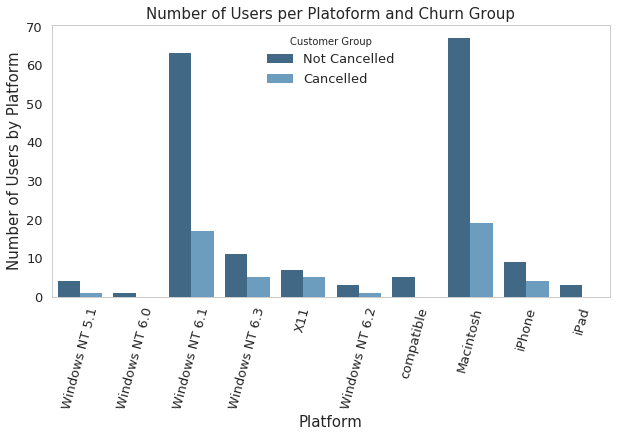

In [65]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x= 'platform', y = 'platform_count', hue = 'phase_cancel', data = df_aux, palette ='Blues_d', ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
plt.legend(labels=['Not Cancelled', 'Cancelled'], title = 'Customer Group')
ax.set_title("Number of Users per Platoform and Churn Group", fontsize=15)
ax.set_xlabel('Platform', fontsize=15)
ax.set_ylabel('Number of Users by Platform', fontsize=15);

The number o users are very similar between Macintosh and Windows NT 6.1. Also between those who have cancelled their account or not.

<a id='days_activity'></a>
#### Days of Activity

Let's see now the time elapased since the users have been registered.

In [66]:
# create a dataframe with the days of activity since the register day till the last event
# or the date of cancellation
df_time_active = df_new.select(['userId', 'event_time', 'reg_time', 'phase_cancel']) \
                       .withColumn('time_active', datediff(df_new.event_time, df_new.reg_time)) \
                       .groupBy(['userId', 'phase_cancel']) \
                       .max('time_active') \
                       .withColumnRenamed('max(time_active)', 'time_active')

In [67]:
df_time_active.show(10)

+------+------------+-----------+
|userId|phase_cancel|time_active|
+------+------------+-----------+
|100010|           0|         55|
|200002|           0|         70|
|   125|           1|         72|
|   124|           0|        131|
|    51|           1|         20|
|     7|           0|         73|
|    15|           0|         57|
|    54|           1|        110|
|   155|           0|         24|
|100014|           1|         85|
+------+------------+-----------+
only showing top 10 rows



In [68]:
df_aux = df_time_active.toPandas()

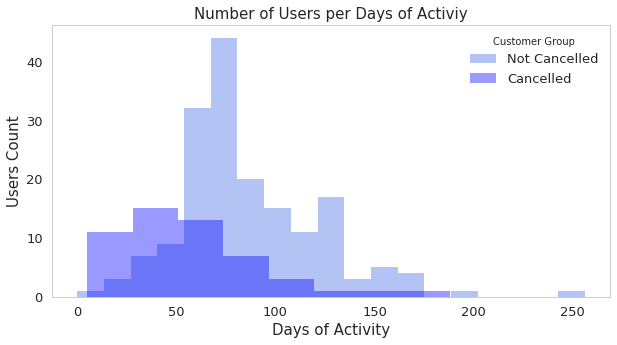

In [69]:
plt.figure(figsize=(10,5))
ax = sns.distplot( df_aux[df_aux.phase_cancel == 0].time_active , 
             color="royalblue",  
             kde=False, 
             label='Not Cancelled')
ax = sns.distplot( df_aux[df_aux.phase_cancel == 1].time_active , 
             color="blue", 
             kde=False, 
             label='Cancelled')
ax.set_title("Number of Users per Days of Activiy", fontsize=15)
ax.set_xlabel('Days of Activity', fontsize=15)
ax.set_ylabel('Users Count', fontsize=15);
# replace title on legend
legend = ax.legend()
legend.set_title("Customer Group")

The distribution is quite different. The users with cancellations tend to have less days of activity. This is the result that we could expect, it seems normal that they were active less days than the users that continue using the service.

<a id='prop_pages'></a>
#### Proportion of Each Page by User

We are going to extract the proportion of pages for each user and compare them. Maybe those who has cancelled their account have a different proportion of Thumbs Up, Thumbs Down, etc. We compare the proportions because it can be normal that the global numbers will be higher for the active users, simply because those who have cancelled their account have had less activity in general.

In [70]:
# define a dataframe wiht the total count for each page and for each user.
df_page_count = df_new.groupBy(['userId', 'page', 'phase_cancel']) \
                  .agg({'page' : 'count'}) \
                  .withColumnRenamed('count(page)', 'page_count') \
                  .groupby(["userId", "phase_cancel"]) \
                  .pivot("page") \
                  .agg(first("page_count")).fillna(0) \
                  .drop('Cancel', 'Cancellation Confirmation')
                  


In [71]:
df_page_count.show(1)

+------+------------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|phase_cancel|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+------------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|100010|           0|    1|         4|              7|        0|    0|   2|  11|     5|     275|         52|            0|       0|               0|             0|          5|       17|      2|
+------+------------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
only showing top 1 row



In [72]:
# a list with the name of the pages
# we are going to monitorize the number of songs and the Downgrades 
# in other features, so we drop it. Next Song is clearly the most clicked page
# and can disturb the othe proportions.
df_page_count = df_page_count.drop('NextSong')
df_page_count = df_page_count.drop('Downgrade')
df_page_count = df_page_count.drop('Submit Downgrade')
# we drop some pages with similar percentages.
df_page_count = df_page_count.drop('Home')
df_page_count = df_page_count.drop('Settings')
df_page_count = df_page_count.drop('Save Settings')
df_page_count = df_page_count.drop('Logout')
df_page_count = df_page_count.drop('About')

column_list = df_page_count.columns[2:]

In [73]:
column_list

['Add Friend',
 'Add to Playlist',
 'Error',
 'Help',
 'Roll Advert',
 'Submit Upgrade',
 'Thumbs Down',
 'Thumbs Up',
 'Upgrade']

In [74]:
# add a column with the sum of all pages for each user
df_page_count = df_page_count.withColumn('total_pages', 
                                         reduce(add, [col(x) for x in column_list]))

In [75]:
# modify each value of each page by its proportion
for field in column_list:
    df_page_count = df_page_count.withColumn(field, col(field)/col('total_pages'))
df_page_count = df_page_count.drop('total_pages')    

In [76]:
df_page_count.show(1)

+------+------------+------------------+-------------------+-----+-------------------+------------------+--------------+--------------------+-------------------+-------------------+
|userId|phase_cancel|        Add Friend|    Add to Playlist|Error|               Help|       Roll Advert|Submit Upgrade|         Thumbs Down|          Thumbs Up|            Upgrade|
+------+------------+------------------+-------------------+-----+-------------------+------------------+--------------+--------------------+-------------------+-------------------+
|100010|           0|0.0449438202247191|0.07865168539325842|  0.0|0.02247191011235955|0.5842696629213483|           0.0|0.056179775280898875|0.19101123595505617|0.02247191011235955|
+------+------------+------------------+-------------------+-----+-------------------+------------------+--------------+--------------------+-------------------+-------------------+
only showing top 1 row



In [77]:
# calculate the mean for all teh users and prepare a pandas dataframe to be visualized
df_aux = df_page_count.groupBy(["phase_cancel"]).mean().toPandas() \
                      .melt('phase_cancel', value_name='mean') \
                      .rename(columns={'variable': 'Page', 'mean': 'mean_proportion'})

In [78]:
df_aux

,phase_cancel,Page,mean_proportion
0,0,avg(phase_cancel),0.000000
1,1,avg(phase_cancel),1.000000
2,0,avg(Add Friend),0.133681
3,1,avg(Add Friend),0.113642
4,0,avg(Add to Playlist),0.184057
5,1,avg(Add to Playlist),0.170835
6,0,avg(Error),0.008663
7,1,avg(Error),0.005612
8,0,avg(Help),0.045092
9,1,avg(Help),0.036769


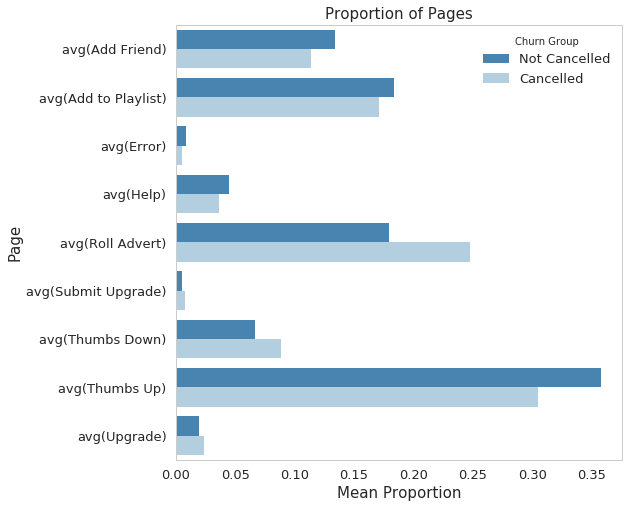

In [79]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x='mean_proportion', 
                y='Page', 
                hue='phase_cancel', 
                data=df_aux[(df_aux.Page != 'avg(phase_cancel)') & 
                            (df_aux.Page != 'avg(NextSong)') &
                            (df_aux.Page != 'avg(Cancel)') &
                            (df_aux.Page != 'avg(CancellationConfirmation)')], 
                palette="Blues_r")

ax.set_title("Proportion of Pages", fontsize=15)
ax.set_xlabel('Mean Proportion', fontsize=15)
ax.set_ylabel('Page', fontsize=15)
# replace labels on legend
legend = ax.legend()
legend.set_title("Churn Group")
for t, l in zip(legend.texts,("Not Cancelled", "Cancelled")):
    t.set_text(l)

We can see some little differences, for example the customers that has not cancelled their account had less Roll Adverts and tend to Thumbs Down a little less. The active users have a bigger proportion of Thumbs Up also.

<a id='mean_time_session'></a>
#### Mean Time per Session by User

It can be also useful to know how much time they used the service when they were active. For example we can explore the mean time per session in minutes for each user.

In [80]:
# create a dataframe with the mean time per session for each user.
df_mean_session_time = df_new.groupby('userId', 'sessionId', 'phase_cancel') \
                             .agg(((Fmax(col('ts').cast('long')) \
                                    - Fmin(col('ts').cast('long')))/(1000*60)).alias('time_session')
                                 ) \
                             .groupby('userId','phase_cancel') \
                             .agg(mean('time_session').alias('time_session')) 

In [81]:
df_mean_session_time.show(10)

+------+------------+------------------+
|userId|phase_cancel|      time_session|
+------+------------+------------------+
|100010|           0|154.48333333333335|
|200002|           0|             266.4|
|   125|           1|29.566666666666666|
|   124|           0| 578.9942528735631|
|    51|           1| 872.3566666666666|
|     7|           0|  87.6404761904762|
|    15|           0| 528.2833333333333|
|    54|           1|322.28963963963963|
|   155|           0| 548.5722222222222|
|100014|           1|184.81388888888887|
+------+------------+------------------+
only showing top 10 rows



Let's see if there are differences in the distribution of these times.

In [82]:
df_aux = df_mean_session_time.toPandas()

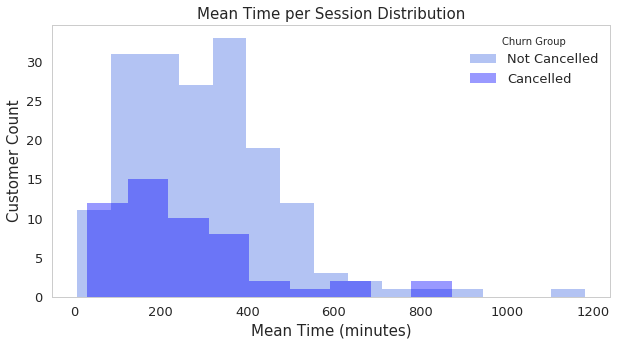

In [83]:
plt.figure(figsize=(10,5))
ax = sns.distplot( df_aux[df_aux.phase_cancel == 0].time_session , 
             color="royalblue",  
             kde=False, 
             label='Not Cancelled')
ax = sns.distplot( df_aux[df_aux.phase_cancel == 1].time_session , 
             color="blue", 
             kde=False, 
             label='Cancelled')
ax.set_title("Mean Time per Session Distribution", fontsize=15)
ax.set_xlabel('Mean Time (minutes)', fontsize=15)
ax.set_ylabel('Customer Count', fontsize=15)
# replace labels on legend
legend = ax.legend()
legend.set_title("Churn Group")
for t, l in zip(legend.texts,("Not Cancelled", "Cancelled")):
    t.set_text(l)

Probably the number of minutes per session tend to be slightly bigger for the users that has not cancelled their account. 

<a id='mean_songs_session'></a>
#### Mean Number of Songs per Session by User

We are going to repeat the process, but with the number of songs per session.

In [84]:
# define a dataframe with the number of NextSong pages per session
df_mean_session_songs = df_new.filter(df_new.page == 'NextSong') \
                              .groupby('userId', 'sessionId', 'phase_cancel') \
                              .agg(count('page').alias('songs_session')) \
                              .groupby('userId','phase_cancel') \
                              .agg(mean('songs_session').alias('songs_session'))

In [85]:
df_mean_session_songs.show(5)

+------+------------+------------------+
|userId|phase_cancel|     songs_session|
+------+------------+------------------+
|100010|           0|39.285714285714285|
|200002|           0|              64.5|
|   125|           1|               8.0|
|   124|           0|145.67857142857142|
|    51|           1|             211.1|
+------+------------+------------------+
only showing top 5 rows



In [86]:
df_aux = df_mean_session_songs.toPandas()

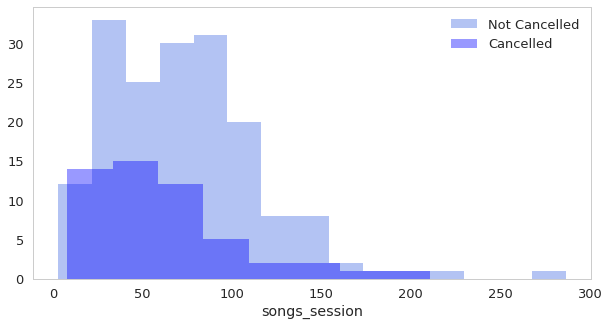

In [87]:
plt.figure(figsize=(10,5))
sns.distplot( df_aux[df_aux.phase_cancel == 0].songs_session , 
             color="royalblue",  
             kde=False, 
             label='Not Cancelled')
sns.distplot( df_aux[df_aux.phase_cancel == 1].songs_session , 
             color="blue", 
             kde=False, 
             label='Cancelled')
plt.legend();

This distribution is very similar to the one wiht the mean time per session.

<a id='mean_sessions_week'></a>
#### Mean Number of Sessions per Week by User

Let's do also some analysis by week, for example the number of sessions by week or the total time by week.

In [88]:
df_new = df_new.withColumn('year', year(df_new.event_time))
df_new = df_new.withColumn('day', dayofmonth(df_new.event_time))
df_new = df_new.withColumn('week', weekofyear(df_new.event_time))

In [89]:
# dataframe with the mean number of sessions by week for each user.
df_mean_sessions_week = df_new.groupby('userId', 'year', 'week', 'sessionId', 'phase_cancel') \
                              .agg(count('sessionId').alias('session_week')) \
                              .groupby('userId','phase_cancel') \
                              .agg(mean('session_week').alias('session_week'))

In [90]:
df_mean_sessions_week.show(5)

+------+------------+-----------------+
|userId|phase_cancel|     session_week|
+------+------------+-----------------+
|100010|           0|54.42857142857143|
|200002|           0|             79.0|
|   125|           1|             11.0|
|   124|           0|166.3793103448276|
|    51|           1|            224.0|
+------+------------+-----------------+
only showing top 5 rows



In [91]:
df_aux = df_mean_sessions_week.toPandas()

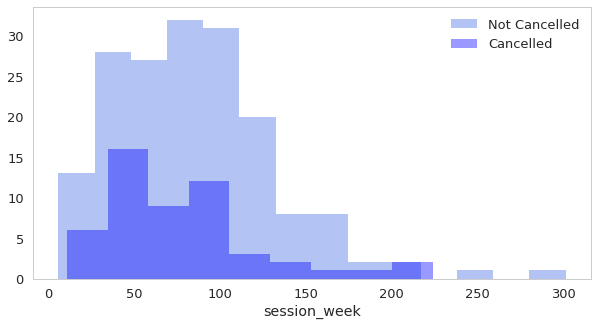

In [92]:
plt.figure(figsize=(10,5))
sns.distplot( df_aux[df_aux.phase_cancel == 0].session_week , 
             color="royalblue",  
             kde=False, 
             label='Not Cancelled')
sns.distplot( df_aux[df_aux.phase_cancel == 1].session_week , 
             color="blue", 
             kde=False, 
             label='Cancelled')
plt.legend();

In this case the distribution is quite simmilar between the two groups of users.

<a id='mean_time_week'></a>
#### Mean Time per Week by User

Let's display also the mean time per week for each user in minutes.

In [93]:
# dataframe with the mean time per week for each user.
df_mean_time_week = df_new.groupby('userId', 'year', 'week', 'sessionId', 'phase_cancel') \
                          .agg(((Fmax(col('ts').cast('long')) \
                                - Fmin(col('ts').cast('long')))/(1000*60)).alias('time_session_week')) \
                          .groupby('userId', 'year', 'week', 'phase_cancel') \
                          .agg(Fsum('time_session_week').alias('time_week')) \
                          .groupby('userId', 'phase_cancel') \
                          .agg(F.mean('time_week').alias('mean_time_week'),
                                F.stddev('time_week').alias('std_time_week'))
df_mean_time_week = df_mean_time_week.fillna(0)

In [94]:
df_mean_time_week.show(5)

+------+------------+------------------+------------------+
|userId|phase_cancel|    mean_time_week|     std_time_week|
+------+------------+------------------+------------------+
|100010|           0|270.34583333333336| 208.3326881656677|
|200002|           0|399.59999999999997|231.23711375507563|
|   125|           1|29.566666666666666|               0.0|
|   124|           0|1865.6481481481485|1161.9738707691788|
|    51|           1|2907.0055555555555|1304.5636154512586|
+------+------------+------------------+------------------+
only showing top 5 rows



In [95]:
df_aux = df_mean_time_week.toPandas()

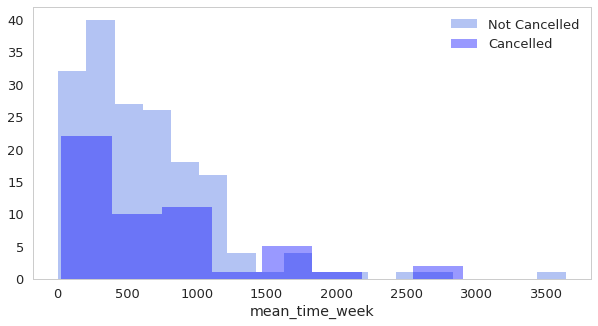

In [96]:
plt.figure(figsize=(10,5))
sns.distplot( df_aux[df_aux.phase_cancel == 0].mean_time_week , 
             color="royalblue",  
             kde=False, 
             label='Not Cancelled')
sns.distplot( df_aux[df_aux.phase_cancel == 1].mean_time_week , 
             color="blue", 
             kde=False, 
             label='Cancelled')
plt.legend();

In this case the number of minutes per week seems to be a little smaller for the users that have cancelled their account.

We can include the standard deviation also for this value by user.

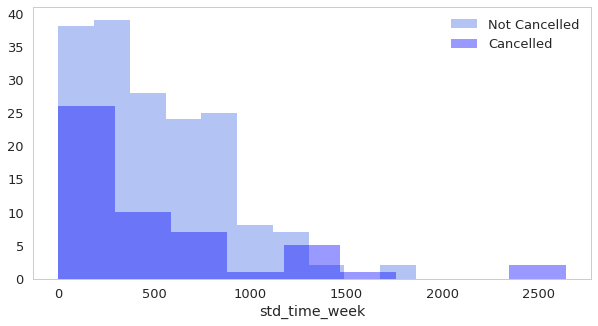

In [97]:
plt.figure(figsize=(10,5))
sns.distplot( df_aux[df_aux.phase_cancel == 0].std_time_week , 
             color="royalblue",  
             kde=False, 
             label='Not Cancelled')
sns.distplot( df_aux[df_aux.phase_cancel == 1].std_time_week , 
             color="blue", 
             kde=False, 
             label='Cancelled')
plt.legend();

<a id='prop_time_week_month'></a>
#### Proportion of Time in the Last Week Respect to the Last Month

We are going to try to see if there have been some change in the behavior of the customers in the last days respect the days before. For example, when a customer cancel his account, Do they use more or less the application the last week respect the last month? To see this we calculate the mean time per day for the last week and divided it for the mean time per day for the last month. If the user has not cancelled the account we'll have the result for the last month of activity.

In [98]:
days = lambda i: i * 86400000
# window to take the most recent value of a user
window = Window.partitionBy('userId').orderBy(col('time_session').desc())
# window to do calculations along the last week
w_last_7_days = (Window.partitionBy("userId").orderBy(F.col('time_session').cast('long')).rangeBetween(-days(7), 0))
# window to do calculations along the last month
w_last_30_days = (Window.partitionBy("userId").orderBy(F.col('time_session').cast('long')).rangeBetween(-days(30), 0))

In [99]:
# a datafrmae with the mean time of the last week, the mean time of the last month and the 
# proportion between them.
df_proportion_time_last_week = df_new.groupby('userId', 'sessionId', 'phase_cancel') \
                           .agg(((Fmax(col('ts').cast('long')) \
                                     - Fmin(col('ts').cast('long')))/(1000*60)).alias('elapsed_time_session'),
                                  Fmax(col('ts').cast('long')).alias('time_session')
                                  ) \
                           .withColumn('mean_time_last_week', 
                                       Fsum('elapsed_time_session').over(w_last_7_days)/7) \
                           .withColumn('mean_time_last_month', 
                                       Fsum('elapsed_time_session').over(w_last_30_days)/30) \
                           .withColumn('time_session', format_time('time_session')) \
                           .withColumn('time_last_week_ratio', (F.col("mean_time_last_week") /  
                                                                F.col("mean_time_last_month"))) \
                           .select('*', row_number().over(window).alias('row_num')) \
                           .where(col('row_num') == 1)

df_proportion_time_last_week = df_proportion_time_last_week.select(['userId',
                                                                   'phase_cancel',
                                                                   'mean_time_last_week',
                                                                   'mean_time_last_month',
                                                                   'time_last_week_ratio'])

df_proportion_time_last_week = df_proportion_time_last_week.fillna(0)

In [100]:
df_proportion_time_last_week.show(5)

+------+------------+-------------------+--------------------+--------------------+
|userId|phase_cancel|mean_time_last_week|mean_time_last_month|time_last_week_ratio|
+------+------------+-------------------+--------------------+--------------------+
|100010|           0| 13.857142857142858|  21.108333333333334|  0.6564773560430883|
|200002|           0|  71.06428571428572|   45.69444444444444|  1.5552062527138517|
|   125|           1|  4.223809523809524|  0.9855555555555555|   4.285714285714286|
|   124|           0| 137.33809523809524|  257.11555555555555|  0.5341493047409972|
|    51|           1|  571.0285714285716|  290.78555555555556|   1.963744623895098|
+------+------------+-------------------+--------------------+--------------------+
only showing top 5 rows



In [101]:
df_aux = df_proportion_time_last_week.toPandas()

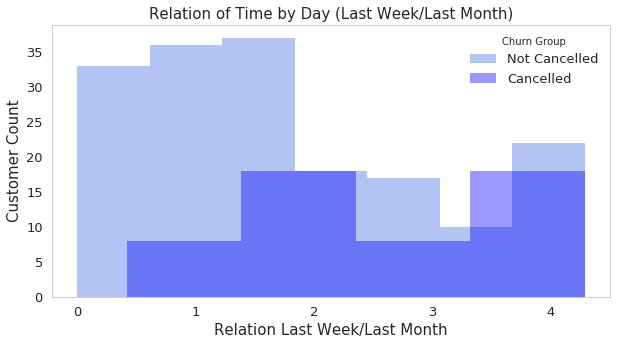

In [102]:
plt.figure(figsize=(10,5))
ax = sns.distplot( df_aux[df_aux.phase_cancel == 0].time_last_week_ratio , 
             color="royalblue",  
             kde=False, 
             label='Not Cancelled')
ax = sns.distplot( df_aux[df_aux.phase_cancel == 1].time_last_week_ratio , 
             color="blue", 
             kde=False, 
             label='Cancelled')

ax.set_title("Relation of Time by Day (Last Week/Last Month)", fontsize=15)
ax.set_xlabel('Relation Last Week/Last Month', fontsize=15)
ax.set_ylabel('Customer Count', fontsize=15)
# replace labels on legend
legend = ax.legend()
legend.set_title("Churn Group")
for t, l in zip(legend.texts,("Not Cancelled", "Cancelled")):
    t.set_text(l)


In general, the users that has less activity the last week tend to be those who has not cancelled the account. Maybe those who are thinking in perform a cancellation try to take advantage of the last days?

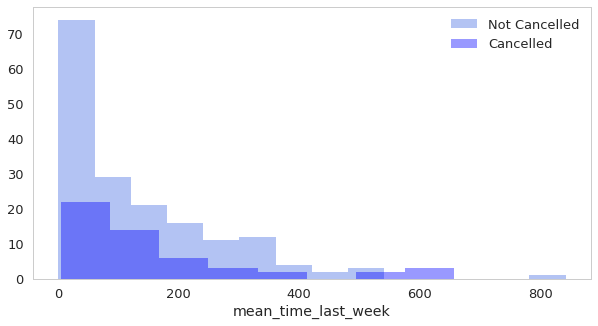

In [103]:
plt.figure(figsize=(10,5))
sns.distplot( df_aux[df_aux.phase_cancel == 0].mean_time_last_week , 
             color="royalblue",  
             kde=False, 
             label='Not Cancelled')
sns.distplot( df_aux[df_aux.phase_cancel == 1].mean_time_last_week , 
             color="blue", 
             kde=False, 
             label='Cancelled')
plt.legend();

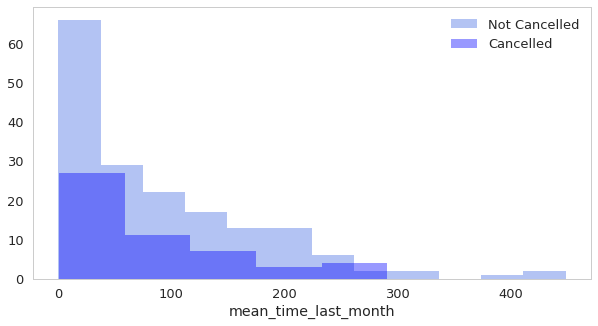

In [104]:
plt.figure(figsize=(10,5))
sns.distplot( df_aux[df_aux.phase_cancel == 0].mean_time_last_month , 
             color="royalblue",  
             kde=False, 
             label='Not Cancelled')
sns.distplot( df_aux[df_aux.phase_cancel == 1].mean_time_last_month , 
             color="blue", 
             kde=False, 
             label='Cancelled')
plt.legend();

<a id='prop_songs_week_month'></a>
#### Proportion of Songs in the Last Week Respect to the Last Month

We can do also a similar analysis, but with the number of songs.

In [105]:
# dataframe with the number of songs per customer in the las week, in the last month and
# the ratio between them
df_proportion_songs_last_week  = df_new.filter(df_new.page=='NextSong') \
                                       .groupby('userId', 'sessionId', 'phase_cancel') \
                                       .agg(Fmax(col('ts').cast('long')).alias('time_session'),
                                            count(col('page')).alias('count')) \
                                       .withColumn('number_songs_last_week', 
                                                   F.sum('count').over(w_last_7_days)) \
                                       .withColumn('number_songs_last_month', 
                                                   F.sum('count').over(w_last_30_days)) \
                                       .withColumn('dense_rank',
                                                   F.dense_rank().over(window)) \
                                                                 .filter(F.col('dense_rank')==1) \
                                       .withColumn('number_songs_ratio', 
                                                   F.col('number_songs_last_week') /
                                                   F.col('number_songs_last_month'))

df_proportion_songs_last_week = df_proportion_songs_last_week.select(['userId',
                                                                      'phase_cancel',
                                                                      'number_songs_last_week',
                                                                      'number_songs_last_month',
                                                                      'number_songs_ratio'])

In [106]:
df_proportion_songs_last_week.show(5)

+------+------------+----------------------+-----------------------+-------------------+
|userId|phase_cancel|number_songs_last_week|number_songs_last_month| number_songs_ratio|
+------+------------+----------------------+-----------------------+-------------------+
|100010|           0|                    24|                    155|0.15483870967741936|
|200002|           0|                   120|                    329|  0.364741641337386|
|   125|           1|                     8|                      8|                1.0|
|   124|           0|                   254|                   2309|0.11000433087916847|
|    51|           1|                   959|                   2111| 0.4542870677404074|
+------+------------+----------------------+-----------------------+-------------------+
only showing top 5 rows



In [107]:
df_aux = df_proportion_songs_last_week.toPandas()

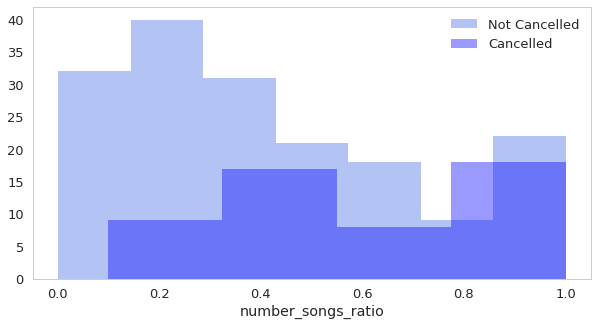

In [108]:
plt.figure(figsize=(10,5))
sns.distplot( df_aux[df_aux.phase_cancel == 0].number_songs_ratio , 
             color="royalblue",  
             kde=False, 
             label='Not Cancelled')
sns.distplot( df_aux[df_aux.phase_cancel == 1].number_songs_ratio , 
             color="blue", 
             kde=False, 
             label='Cancelled')
plt.legend();

The distribution is similar to the proportion of time spended on the app the last week respect the last month.

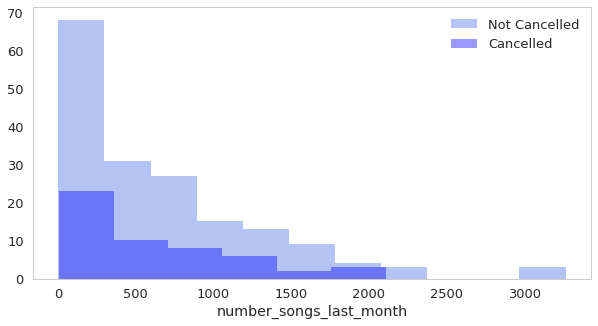

In [109]:
plt.figure(figsize=(10,5))
sns.distplot( df_aux[df_aux.phase_cancel == 0].number_songs_last_month , 
             color="royalblue",  
             kde=False, 
             label='Not Cancelled')
sns.distplot( df_aux[df_aux.phase_cancel == 1].number_songs_last_month , 
             color="blue", 
             kde=False, 
             label='Cancelled')
plt.legend();

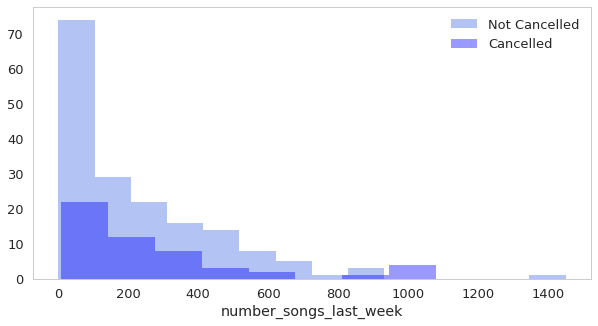

In [110]:
plt.figure(figsize=(10,5))
sns.distplot( df_aux[df_aux.phase_cancel == 0].number_songs_last_week , 
             color="royalblue",  
             kde=False, 
             label='Not Cancelled')
sns.distplot( df_aux[df_aux.phase_cancel == 1].number_songs_last_week , 
             color="blue", 
             kde=False, 
             label='Cancelled')
plt.legend();

<a id='mean_artists_week'></a>
#### Mean Number of Different Artists per Week

We can add also the mean of different artists per week.

In [111]:
# dataframe with the mean number of different artists per week
df_num_artist_week = df_new.select('userId', 'year', 'week', 'sessionId', 'phase_cancel',
                                   'page','artist', 'ts') \
                            .filter(df_new.page=='NextSong') \
                            .dropDuplicates(subset=['userId', 'phase_cancel', 'year', 
                                                    'week', 'artist']) \
                            .groupby('userId', 'year', 'week', 'phase_cancel') \
                            .agg(count('artist').alias('number_artists_week')) \
                            .groupby('userId', 'phase_cancel') \
                            .agg(mean('number_artists_week').alias('mean_artists_week'))


In [112]:
df_num_artist_week.show(5)

+------+------------+------------------+
|userId|phase_cancel| mean_artists_week|
+------+------------+------------------+
|100010|           0|              66.0|
|200002|           0|             92.25|
|   125|           1|               8.0|
|   124|           0|375.55555555555554|
|    51|           1|             565.0|
+------+------------+------------------+
only showing top 5 rows



In [113]:
df_aux = df_num_artist_week.toPandas()

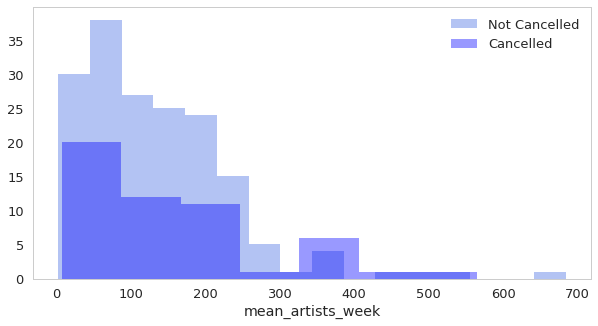

In [114]:
plt.figure(figsize=(10,5))
sns.distplot( df_aux[df_aux.phase_cancel == 0].mean_artists_week , 
             color="royalblue",  
             kde=False, 
             label='Not Cancelled')
sns.distplot( df_aux[df_aux.phase_cancel == 1].mean_artists_week , 
             color="blue", 
             kde=False, 
             label='Cancelled')
plt.legend();

Some users have really listening to a really big number of different artists.

<a id='total_artists'></a>
#### Total Number of Different Artists

We can take a look also to the total number of different artists by user.

In [115]:
# dataframe with the total number of artist listened by each user
df_num_artist = df_new.select('userId', 'phase_cancel', 'page','artist') \
                            .filter(df_new.page=='NextSong') \
                            .dropDuplicates(subset=['artist']) \
                            .groupby('userId', 'phase_cancel') \
                            .agg(count(col('artist')).alias('count_artist'))

In [116]:
df_num_artist.show(5)

+------+------------+------------+
|userId|phase_cancel|count_artist|
+------+------------+------------+
|    55|           0|          20|
|   149|           0|           7|
|   120|           0|         108|
|   126|           0|         171|
|   127|           0|          55|
+------+------------+------------+
only showing top 5 rows



In [117]:
df_aux = df_num_artist.toPandas()

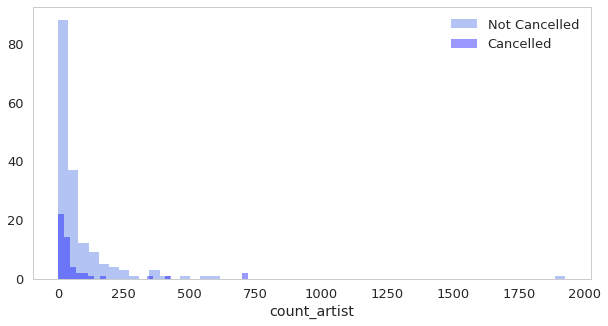

In [118]:
plt.figure(figsize=(10,5))
sns.distplot(df_aux[df_aux.phase_cancel == 0].count_artist ,
             color="royalblue",  
             kde=False, 
             label='Not Cancelled')
sns.distplot( df_aux[df_aux.phase_cancel == 1].count_artist , 
             color="blue", 
             kde=False, 
             label='Cancelled')

plt.legend();

<a id='feat_eng'></a>
## Feature Engineering

Now that we have some possible features, we are going to proceed to join them in a single dataframe.

This is the list of available features that we could use:

* **Numerical Features**


    - number of downgraes by user (Integer)
    - days of activity (Integer)
    - proportion of each type of page (Float between 0 and 1)
    - mean time in minutes per session (Float)
    - mean number of songs per session (Float)
    - mean number of sessions per week (Float)
    - mean time of use in minutes per week (Float)
       
    - mean time per day in the last week (Float)
    - mean time per day in the last month (Float)
    - proportion between the time of use per day in the last week compared
      with the time of use per day in the last month (Float between 0 and 1)
         
    - number of songs in the last week (Float)
    - number of songs in the last month (Float)
    - proportion of the number of songs in the last week compared
      with the number of songs in the last month. (Float between 0 and 1)

    - mean number of different artists per week (Float)
    - total number of different artists (Integer)


* **Categorical Features**


    - gender
    - level
    - platform



In the next part we prepare the categorical variables to be used in the models and join all the features in a single dataframe.

In [119]:
# first we get the gender and the churn_label from the original dataframe
df_features = df_new.select('userId', 'churn_label', 'gender') \
                    .dropDuplicates()
df_features.persist()


# udf to to change the letters 'M' and 'F' by 0 and 1 in gender
udf_gender = udf(lambda x: 0 if x == 'M' else 1, IntegerType())
# change the gender to a numerical value
df_features = df_features.withColumn('gender', udf_gender('gender'))

# udf to to change 'free' and 'paid' by 0 and 1 in level
udf_level = udf(lambda x: 0 if x == 'free' else 1, IntegerType())
# change the level to a numerical value
df_level = df_level.withColumn('level', udf_level('level'))

# transform plaform column to dummy variables
platforms_list =  df_platform.select('platform').distinct().rdd.flatMap(lambda x: x).collect()
platform_expr = [F.when(F.col('platform') == plat, 1).otherwise(0).alias(plat) 
                 for plat in platforms_list]
df_platform = df_platform.select('userId', *platform_expr)

# join all the dataframes into df_features
# list with feature dataframes that we have created before
list_feat_df = [df_level, 
                df_downgrades, 
                df_time_active, 
                df_platform, 
                df_page_count,
                df_mean_session_time, 
                df_mean_session_songs, 
                df_mean_time_week, 
                df_num_artist_week,
                df_mean_sessions_week, 
                df_proportion_time_last_week, 
                df_proportion_songs_last_week,
                df_num_artist]

# join the feature dataframes to the global feature dataframe df_features
for feat_df in list_feat_df:
    feat_df = feat_df.drop('phase_cancel')
    df_features = df_features.join(feat_df, 
                                   df_features.userId == feat_df.userId, 
                                   'left').drop(feat_df.userId)


# rename all the columns to avoid dots and spaces
oldColumns = df_features.schema.names
newColumns = []
for column in oldColumns:
    newColumns.append(column.replace(' ', '_').replace('.', '_'))

df_features = reduce(lambda df_features, idx: df_features.withColumnRenamed(oldColumns[idx], 
                                                                            newColumns[idx]), 
                                              range(len(oldColumns)), df_features)

# fill any possible nan  with 0
df_features = df_features.fillna(0)

This is the final dataframe with all the features gathered.

In [120]:
df_features.show(1)

+-----------+------+------+-----+--------------+-----------+----+---+--------------+------+--------------+---------+--------------+----------+--------------+--------------+------------------+-------------------+-----+-------------------+------------------+--------------+--------------------+-------------------+-------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-------------------+--------------------+--------------------+----------------------+-----------------------+-------------------+------------+
|churn_label|gender|userId|level|num_downgrades|time_active|iPad|X11|Windows_NT_6_3|iPhone|Windows_NT_6_2|Macintosh|Windows_NT_5_1|compatible|Windows_NT_6_0|Windows_NT_6_1|        Add_Friend|    Add_to_Playlist|Error|               Help|       Roll_Advert|Submit_Upgrade|         Thumbs_Down|          Thumbs_Up|            Upgrade|      time_session|     songs_session|    mean_time_week|    std_time_week|mean_ar

Obviously some of this features are very similar, so we are going to search for some correlations between them.

In [121]:
# we define a Pandas dataframe to dra the correlations between variables in a heatmap
pd_features = df_features.toPandas()
pd_features = pd_features.drop(columns = ['userId'])

In [122]:
categorical_features = ['gender', 'level', 'iPad', 'X11', 'Windows_NT_6_3', 
                        'iPhone', 'Windows_NT_6_2', 'Macintosh', 'Windows_NT_5_1', 
                        'Windows_NT_6_0', 'Windows_NT_6_1', 'compatible']

In [123]:
numerical_features = ['Add_Friend', 'Add_to_Playlist', 
                      'Error', 'Help', 'Roll_Advert', 
                      'Submit_Upgrade', 'Thumbs_Down', 'Thumbs_Up', 
                      'Upgrade', 'time_session', 'songs_session', 'time_active', 'num_downgrades',
                      'mean_time_week', 'std_time_week', 'mean_artists_week', 'session_week', 'mean_time_last_week', 
                      'mean_time_last_month', 'time_last_week_ratio', 'number_songs_last_week', 
                      'number_songs_last_month', 'number_songs_ratio', 'count_artist']

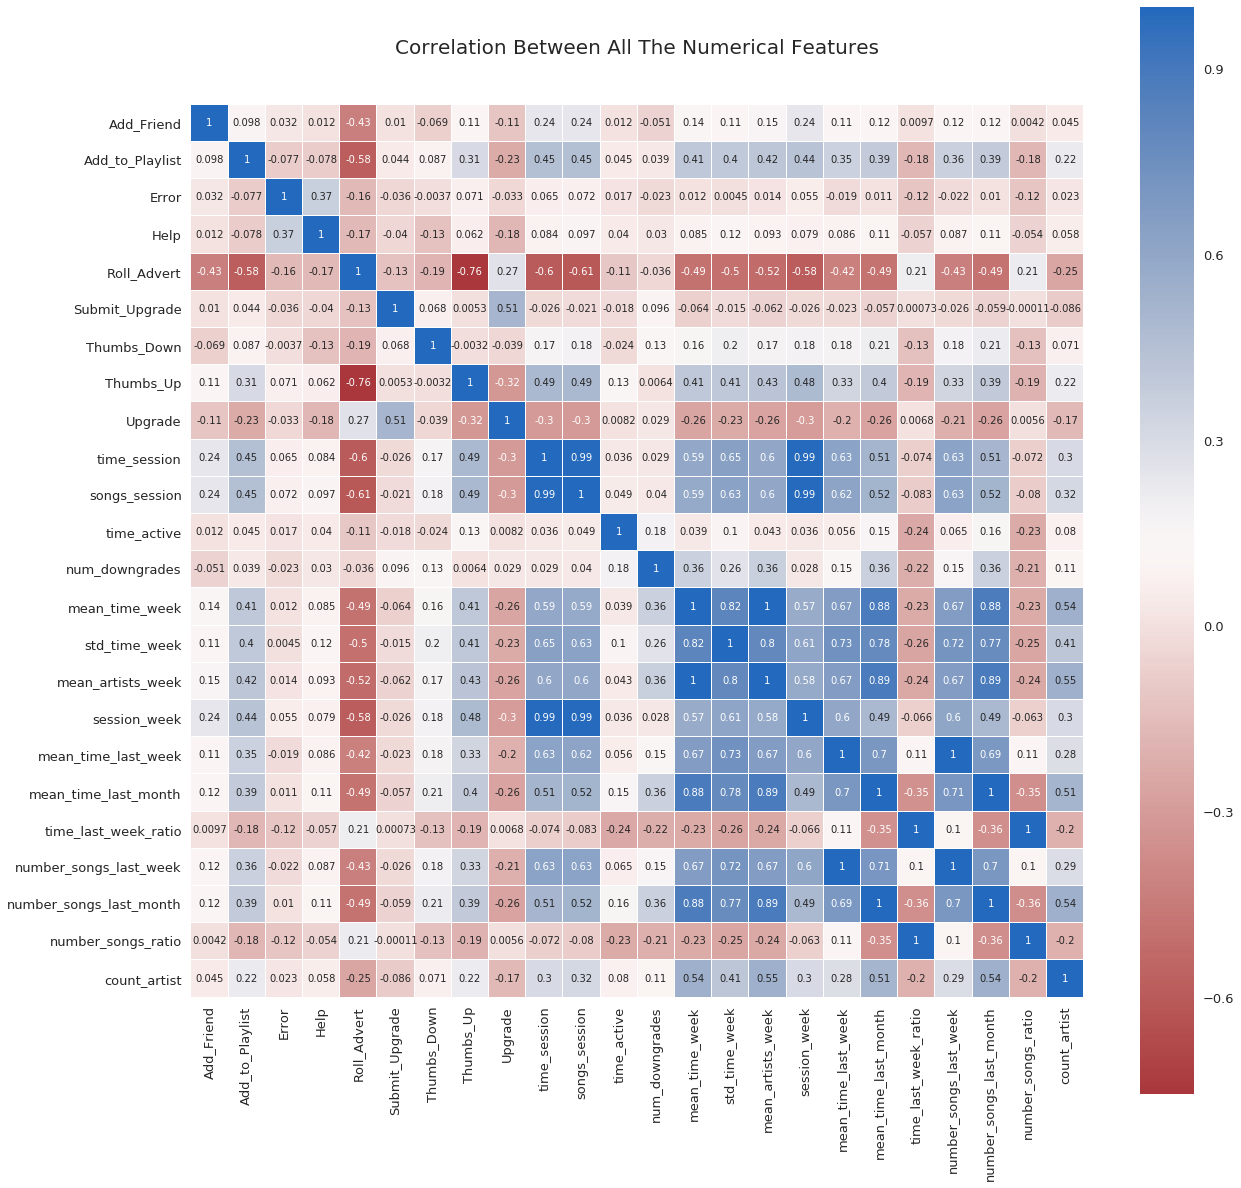

In [124]:
# correlation matrix between the numerical features
plt.figure(figsize=(20,20))
plt.title('Correlation Between All The Numerical Features', y=1.05, size=20)
sns.heatmap(pd_features[numerical_features].corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap = 'vlag_r', linecolor='white', annot=True,
           annot_kws={"fontsize":10});

There are some features that correlated between them, it is logical because some of them are very similar, but if we simply drop them we get a much worse result in the predictions. So we have finally decided to apply PCA to the Logistic Regression and Lineas SVC models to avoid possible collinearities. We are not going to have information about the coefficients of the features, but we can extract the feature importance from other models like Random Forests, Decision Trees or GBT.

I was searching and it seems that it can be possible to get the features ivolved in each PCA component, but we are not going to do that by the moment.

We save the dataframe with all the features into a file to make easier the modeling part.

In [125]:
# save the features result in a file to used it later.
df_features.write.format('json').mode("overwrite").save('sparkify_features.json')

<a id='modeling'></a>
## Modeling
We will split the full dataset into train and validation sets. Then we will test out our machine learning model and we will evaluate their accuracy to find the winning model.

Firstly, we are going to read the file with the features that we have saved before. So we don't need to execute all the previous work.

In [126]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()


In [127]:
# read the features from the analysis above.
df_features = spark.read.json('sparkify_features.json')
df_features.cache()

DataFrame[Add_Friend: double, Add_to_Playlist: double, Error: double, Help: double, Macintosh: bigint, Roll_Advert: double, Submit_Upgrade: double, Thumbs_Down: double, Thumbs_Up: double, Upgrade: double, Windows_NT_5_1: bigint, Windows_NT_6_0: bigint, Windows_NT_6_1: bigint, Windows_NT_6_2: bigint, Windows_NT_6_3: bigint, X11: bigint, churn_label: bigint, compatible: bigint, count_artist: bigint, gender: bigint, iPad: bigint, iPhone: bigint, level: bigint, mean_artists_week: double, mean_time_last_month: double, mean_time_last_week: double, mean_time_week: double, num_downgrades: bigint, number_songs_last_month: bigint, number_songs_last_week: bigint, number_songs_ratio: double, session_week: double, songs_session: double, std_time_week: double, time_active: bigint, time_last_week_ratio: double, time_session: double, userId: string]

In [128]:
categorical_features = ['gender', 'level', 'iPad', 'Windows_NT_6_3', 'X11',
                        'iPhone', 'Windows_NT_6_2', 'Macintosh', 'Windows_NT_5_1', 
                        'Windows_NT_6_0', 'Windows_NT_6_1', 'compatible']

In [129]:
numerical_features = ['Add_Friend', 'Add_to_Playlist', 
                      'Error', 'Help', 'Roll_Advert', 
                      'Submit_Upgrade', 'Thumbs_Down', 'Thumbs_Up', 
                      'Upgrade', 'time_session', 'songs_session', 'time_active', 'num_downgrades',
                      'mean_time_week', 'std_time_week', 'mean_artists_week', 'session_week', 'mean_time_last_week', 
                      'mean_time_last_month', 'time_last_week_ratio', 'number_songs_last_week', 
                      'number_songs_last_month', 'number_songs_ratio', 'count_artist']

In [130]:
all_features = categorical_features + numerical_features

In [131]:
df_features.printSchema()

root
 |-- Add_Friend: double (nullable = true)
 |-- Add_to_Playlist: double (nullable = true)
 |-- Error: double (nullable = true)
 |-- Help: double (nullable = true)
 |-- Macintosh: long (nullable = true)
 |-- Roll_Advert: double (nullable = true)
 |-- Submit_Upgrade: double (nullable = true)
 |-- Thumbs_Down: double (nullable = true)
 |-- Thumbs_Up: double (nullable = true)
 |-- Upgrade: double (nullable = true)
 |-- Windows_NT_5_1: long (nullable = true)
 |-- Windows_NT_6_0: long (nullable = true)
 |-- Windows_NT_6_1: long (nullable = true)
 |-- Windows_NT_6_2: long (nullable = true)
 |-- Windows_NT_6_3: long (nullable = true)
 |-- X11: long (nullable = true)
 |-- churn_label: long (nullable = true)
 |-- compatible: long (nullable = true)
 |-- count_artist: long (nullable = true)
 |-- gender: long (nullable = true)
 |-- iPad: long (nullable = true)
 |-- iPhone: long (nullable = true)
 |-- level: long (nullable = true)
 |-- mean_artists_week: double (nullable = true)
 |-- mean_time_l

Firslty we are going to define some functions that will make easier and more structered the modelling part.

The next function adds a column with the proportion of each class. This will allow us to apply the Weighted Logistic Model to give more relevance to the minority label (churn = 1). We want to miss as few customers of this class as possible.

In [132]:
def add_weight_column(df): 
    """
    add a column with the proportion of each class in the label column 

    Args:
        (Spark DafaFrame) df - data frame with features and label.
    Returns:
        (Spark DafaFrame) weighted_dataset - The same dataframe with the new column.
    """   
    num_positives = df.filter(df.label == 0).count()
    dataset_size = df.count()
    balancing_ratio = float((dataset_size - num_positives) / dataset_size)


    calculate_weights = udf(lambda x: (1 * balancing_ratio) if (x == 0.0)  \
                                      else (1 * (1.0 - balancing_ratio)), FloatType()) 

    weighted_dataset = df.withColumn('weight_col', calculate_weights('label'))

    return weighted_dataset

To fit and to make predcitions with the models we need to gather all the features into a vector. We need to scale the numerical features in order to work with all of them in the same range. We are going to scale both the mean and the standard deviation. Then we are going to create a dataframe with two columns, one with the label (`churn_label`) and another with a vector containing all the features, the categorical and the numerical scaled.

At the same time this data will also contain another colum with  a vector of features reduced to k principal components. We are going to indicate to each model which column, `features` or `features_pca`, we want to work with.

In [133]:
def get_vectorized_df(df, numerical_features, categorical_features, k = 15):
    """
    It receives a dataframe with the label and each feature in one different column.
    It scales the numerical features in order to they have se same mean and std.
    Group all the features into a vector.
    Returns a Spark DataFrame with three columns: the label, the vector with the features and 
    a vector with the k principal components of the features.

    Args:
        (Spark DafaFrame) df - data frame with the features and the label.
        (list) numerical_features - a list with the numerical features.
        (list) categorical_features - a list with the categorical features.
        (integer) k - number of features se want to include in the pca transformation
    Returns:
        (Spark DafaFrame) df_result - A data frame with two columns: label and vector with features. 
    """ 
    # create a vector with the numerical features in the column 'numverical_features'
    vector = VectorAssembler(inputCols = numerical_features, 
                             outputCol ='numerical_features')
    df_temp = vector.transform(df)
    
    toDense = lambda v: Vectors.dense(v.toArray())
    toDenseUdf = F.udf(toDense, VectorUDT())
    df_temp.withColumn('numerical_features', toDenseUdf('numerical_features'))

    # scale all the features in order to have the same mean (0) and the same std (1)
    scaler = StandardScaler(withMean = True, 
                            withStd = True, 
                            inputCol ='numerical_features', 
                            outputCol = 'scaled_features' )
    scaler_model = scaler.fit(df_temp)
    df_scaled = scaler_model.transform(df_temp)
    

    # create a dataframe with the column 'churn_label' as 'label' and a vector with the categorical
    # features more the numerical scaled features
    vector = VectorAssembler(inputCols = categorical_features + 
                                         ['scaled_features'], 
                             outputCol='all_features')
    df_scaled = vector.transform(df_scaled)
    df_result = df_scaled.select(df_scaled.churn_label.alias('label'), 
                                df_scaled.all_features.alias('features'))
    
    # reduce the features to 10 principal components
    pca = PCAml(k=k, inputCol='features', outputCol='features_pca')
    model_pca = pca.fit(df_result)
    df_result = model_pca.transform(df_result)
    
    df_result = df_result.select(df_result.label.alias('label'), 
                                df_result.features,
                                df_result.features_pca)
    
    return df_result


In the next sept we will going to split the dataframe before in two parts: A dataset for the training and a dataset for the validation. 

In [134]:
def get_train_validation_sets(df, seed = 42, prop = 0.8):
    """
    Splits a data frame of features into a train and a validation datasets.
    
    Args:
    (Spark DafaFrame) df - dataframe with two columns: the label and a vector with the features.
    (Int) seed - seed to do the random split
    (Float) prop - proportion of rows assigned to the train set. 
    
    Returns:
    (Spark DafaFrame) train_set - 70% of the rows of df.
    (Spark DafaFrame) validation_set - 30% of the rows of df.
    """
    # divide the the dataframe 'df_result' into a train set and a validation set
    train_set, validation_set = df.randomSplit([prop, 1-prop], seed)
    return train_set, validation_set

In this function we fit all the models contained into a list inside a dictionary wihch also have a list with the names of the models and the another list with the param grids for each model.

In [135]:
def fit_models (models_data_dict, train_set, metric = 'f1', print_out = True):
    """
    It receives a dictionary with keys: 'modelName', 'estimators' and 'paramGrids'
       - the first key is a list with the name of each model.
       - the second key is the list of models we want to fit.
       - the third key is a list with the param grids for each model.
    It also receives the train_set and the metric we want to use.
    It fits each model and returns a dictionary with the name of the models as key and the model
    fitted as value.

    Args:
        (dictionary) models_data_dict - the models and the param grids for each model
        (Spark DafaFrame) train_set - data frame with the train dataset.
        (String) metric - the metric we want to use to fit the models.
        (Boolean) print_out - if we want to print out or not messages of time elapsed.
                              Put it to False if you want to call the fitting iterativily many times.
        
    Returns:
        (dictionary) models_result_dict - A dictionary with all the models fitted. 
    """ 
    
    start_total = time.time()
    if print_out == True:
        print('\n-------------------------')
        print('Fitting the Models')
        print('-------------------------')
    estimators =  models_data_dict['estimators']
    models_result_dict = {}
    # for each model in models_data_dict
    for index, estimator in enumerate(estimators):
        start_model = time.time()
        if print_out == True:
            print('Starting the fitting of {}.'.format(models_data_dict['modelName'][index]))
        # extract the paramGrid from the dictionary
        paramGrid = models_data_dict['paramGrids'][index]
        # define a Pipeline (it wouldn't be necessary in this case)
        pipeline = Pipeline(stages=[estimator])

        # define a Cross Validation model using 'f1' as the metric
        cvModel = CrossValidator(estimator = pipeline,
                                 estimatorParamMaps = paramGrid,
                                 evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                                 numFolds = 3)
        

        cvFittedModel = cvModel.fit(train_set)
            
        end_model = time.time()
        if print_out == True:
            print('Time elapsed fitting model {}: {}s.'.format(models_data_dict['modelName'][index], 
                                                           round(end_model-start_model),1))
        
        # add the model fittet to a dictionary of models
        models_result_dict[models_data_dict['modelName'][index]] = cvFittedModel
        
    end_total = time.time()
    if print_out == True:
        print('Time elapsed fitting all models: {}s.'.format(round(end_total-start_total),1))
    
    # return the result with all the models fitted
    return models_result_dict



A function to print a report of the best params of the paramGrids for each model.

In [136]:
def print_best_params(models_result_dict):
    """
    It receives a dictionary with the models fitted and print the best params from the paramGrid
    used in the fitting.
    
    Args: 
         (dictionary) models_result_dict - a dictionary with the name of the models as keys 
                                           and the models fitted as values.
    """
    print('\n-------------------------')
    print('Best Params of the Models')
    print('-------------------------')
    #for model in models_result_dict:
    for key in models_result_dict:
        print('Best Params for {}'.format(key))
        # extract the fitted model
        model = models_result_dict[key]
        for value in model.getEstimatorParamMaps()[np.argmax(model.avgMetrics)].items():
            print('    Best Param ({}): {}'.format(value[0].name, value[1]))

We have defined also a funtion to save the models in files.

In [137]:
def save_models(models_result_dict):
    """
    It receives a dictionary with the models fitted and it save it in a file
    
    Args: 
         (dictionary) models_result_dict - a dictionary with the name of the models as keys 
                                           and the models fitted as values.
    """
    print('\n-------------------------')
    print('Saving the models')
    print('-------------------------')
    #for model in models_result_dict:
    for key in models_result_dict:
        print('Saving {}'.format(key))
        # extract the fitted model
        model = models_result_dict[key].bestModel.stages[-1]
        model.write().overwrite().save(key)

Another function to make predictions on the validation set with the fitted models.

In [138]:
def predict_validation_set(models_result_dict, validation_set):
    '''
    It receives a dictionary with the fitted models and the validation_set dataframe.
    Use the MulticlassClassificationEvaluator to evaluate each model and returns a dictionary
    with the predicted values for each model.
    It also returs a dataframe with the values of f1 and accuracy for the class 0 and 1
    for each model.
    
    Args:
         (dictionary) models_result_dict - a dictionary with the name of the models as keys 
                                           and the models fitted as values.
         (Spark DataFrame) validation_set - the data set used to perform the validations.
    
    Returns:
         (dictionary) all_predictions - a dictionary with the name of the models as keys 
                                        and the predictions as value.
         (Pandas DataFrmae) f1_results - a dataframe with the f1 and the accuracy for the 
                                         class 0, 1 and the total.
    '''
    
    all_predictions = {}
    f1_results = pd.DataFrame(columns=['Model','F1_Total', 'F1_0','F1_1',
                                       'Accuracy_Total', 'Accuracy_0', 'Accuracy_1'])
    for key in models_result_dict:
        # extract the fitted model
        model = models_result_dict[key]
        # apply transform to the validation data set
        prediction = model.transform(validation_set)
        # add the prediction obteined to the dictionary result
        all_predictions[key] = prediction
        # get the values of f1, precision and recall for the class 0, 1 and total
        evaluator= MulticlassClassificationEvaluator(predictionCol='prediction')
        
        f1_total = evaluator.evaluate(prediction.select('label', 
                                                        'prediction'), 
                                                        {evaluator.metricName: 'f1'})
        f1_0 = evaluator.evaluate(prediction.select('label', 
                                                    'prediction').filter(prediction.label == 0), 
                                                  {evaluator.metricName: 'f1'})
        f1_1 = evaluator.evaluate(prediction.select('label', 
                                                    'prediction').filter(prediction.label == 1), 
                                                  {evaluator.metricName: 'f1'})
        accuracy_total = evaluator.evaluate(prediction.select('label', 
                                                        'prediction'), 
                                                        {evaluator.metricName: 'accuracy'})
        accuracy_0 = evaluator.evaluate(prediction.select('label', 
                                                    'prediction').filter(prediction.label == 0), 
                                                  {evaluator.metricName: 'accuracy'})
        accuracy_1 = evaluator.evaluate(prediction.select('label', 
                                                    'prediction').filter(prediction.label == 1), 
                                                  {evaluator.metricName: 'accuracy'})
    
        # add the results to a dataframe
        f1_results = f1_results.append({'Model': key, 
                                        'F1_Total': f1_total, 
                                        'F1_0': f1_0, 
                                        'F1_1': f1_1,
                                        'Accuracy_Total': accuracy_total, 
                                        'Accuracy_0': accuracy_0, 
                                        'Accuracy_1': accuracy_1}, 
                                       ignore_index=True)
    
    return all_predictions, f1_results
        

This function will calculate the prediction matrix and it will return a seaborn heatmap to draw it.

In [139]:
def draw_confussion_matrix(prediction, model_name):
    """
    It receives a prediction dataframe and use MulticlassMetrics to draw the confusion matrix.
    
    Args:
         (Spark DataFrame) prediction - A spark DataFrame with the label and predictions.
         (Sgtring) model_name - The name of the model.
    """
    
    sns.set(font_scale=1)
    results = prediction.select(['prediction', 'label'])
    results = results.withColumn('label', results['label'].cast(FloatType()))
    prediction_labels=results.rdd
    metrics = MulticlassMetrics(prediction_labels)
    cm=metrics.confusionMatrix().toArray()
    
    ax = sns.heatmap(cm, annot=True, cmap='Blues', annot_kws={"size":12})
    
    ax.set_title(model_name, fontsize = 12)
    ax.set_xlabel('Predicted', fontsize = 12)
    ax.set_ylabel('Actual', fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    sns.set(font_scale=1)
    return ax

Now we are going to prepare a dictionary with keys: `modelName`, `estimators` and `paramGrids`. The values will be a list with the names of the models, a list with the models (estimators) and a list with the param grids. It will be used in the functions we defined above.

In [140]:
# initializes the list of paramGrids, the list of models and the list of model names.
paramGrid_list = []
estimator_list = []
estimator_name_list = []

# define paramgrid and model for Logistic Regression
# we indicate the column 'features_pca' as the column of features
estimator_lr =  LogisticRegression(featuresCol = 'features_pca')
paramGrid_lr = ParamGridBuilder() \
                 .addGrid(estimator_lr.maxIter,[100]) \
                 .addGrid(estimator_lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
                 .addGrid(estimator_lr.regParam,[0.0, 0.05, 0.1]) \
                 .build()
paramGrid_list.append(paramGrid_lr)
estimator_list.append(estimator_lr)
estimator_name_list.append('LogisticRegression')

# define paramgrid and model for Logistic Regression Weightged
# we indicate the column 'features_pca' as the column of features
estimator_lr_weight = LogisticRegression(featuresCol = 'features_pca').setWeightCol('weight_col')
paramGrid_lr_weight = ParamGridBuilder() \
                 .addGrid(estimator_lr.maxIter,[100]) \
                 .addGrid(estimator_lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
                 .addGrid(estimator_lr.regParam,[0.0, 0.05, 0.1]) \
                 .build()
paramGrid_list.append(paramGrid_lr_weight)
estimator_list.append(estimator_lr_weight)
estimator_name_list.append('LogisticRegressionWeighted')

# define paramgrid and model for Random Forsests
estimator_rf =  RandomForestClassifier(seed=42)
paramGrid_rf = ParamGridBuilder() \
                .addGrid(estimator_rf.numTrees,[2, 5, 10, 15, 20, 25]) \
                .build()
paramGrid_list.append(paramGrid_rf)
estimator_list.append(estimator_rf)
estimator_name_list.append('RandomForestClassifier')

# define paramgrid and model for Decision Trees
estimator_dt =  DecisionTreeClassifier(seed=42)
paramGrid_dt = ParamGridBuilder() \
                 .addGrid(estimator_dt.maxDepth,[3, 5, 10]) \
                 .addGrid(estimator_dt.impurity,['entropy', 'gini']) \
                 .build()
paramGrid_list.append(paramGrid_dt)
estimator_list.append(estimator_dt)
estimator_name_list.append('DecisionTreeClassifier')


# define paramgrid and model for GBT
estimator_gbt =  GBTClassifier(seed=42)
paramGrid_gbt = ParamGridBuilder() \
                  .addGrid(estimator_gbt.maxDepth,[3, 5, 10]) \
                  .addGrid(estimator_gbt.maxBins ,[10, 5]) \
                  .addGrid(estimator_gbt.maxIter ,[50, 20]) \
                  .build()
paramGrid_list.append(paramGrid_gbt)
estimator_list.append(estimator_gbt)
estimator_name_list.append('GBTClassifier')

# define paramgrid and model for SVC
estimator_svc =  LinearSVC(featuresCol = 'features_pca').setWeightCol('weight_col')
paramGrid_svc = ParamGridBuilder() \
                  .addGrid(estimator_svc.maxIter, [10, 100, 1000]) \
                  .addGrid(estimator_svc.regParam, [0.01,0.1,10.0,100.0]) \
                  .build()
paramGrid_list.append(paramGrid_svc)
estimator_list.append(estimator_svc)
estimator_name_list.append('LinearSVC')

# the estimator and the paramGrid to a dictionary of lists with info to fit the models
models_dict = {'modelName': estimator_name_list, 'paramGrids': paramGrid_list, 'estimators': estimator_list}

Perform the vectorization of the dataframe `df_features`.

In [141]:
df_vector = get_vectorized_df(df_features, numerical_features, categorical_features, k= 18)
df_vector.show(5)

+-----+--------------------+--------------------+
|label|            features|        features_pca|
+-----+--------------------+--------------------+
|    0|[1.0,1.0,0.0,0.0,...|[0.97007560037571...|
|    0|[1.0,1.0,0.0,0.0,...|[-1.1431782216121...|
|    0|[0.0,1.0,0.0,0.0,...|[-2.1385004784755...|
|    0|[1.0,0.0,0.0,0.0,...|[4.26535239431993...|
|    0|[0.0,0.0,0.0,0.0,...|[4.55586997546134...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [142]:
df_vector.take(1)

[Row(label=0, features=DenseVector([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.4144, -0.7632, 0.1703, -0.2939, 1.3131, 1.0781, -0.3054, -1.2691, 0.8349, -0.5778, -0.5559, 2.4766, 2.9268, -0.396, -0.1202, -0.3883, -0.5098, 0.4111, -0.0291, 0.2177, 0.4166, -0.0385, 0.228, -0.1609]), features_pca=DenseVector([0.9701, 1.3902, 2.0869, -0.935, -1.6553, 0.8075, 2.6073, 0.8515, -0.4984, 0.6411, -0.8735, 0.6632, -0.4684, 0.9063, 0.318, 0.529, -0.3705, 0.7492]))]

Split the dataframe `df_vector` into a train and validation dataset. We add a column to the train data set with the weight of each class to be used in Weighted Logistic Regression Model.

In [143]:
train_set, validation_set = get_train_validation_sets(df_vector, seed = 42, prop = 0.7)
train_set = add_weight_column(train_set)
train_set = train_set.cache()

In [144]:
train_set.show(5)

+-----+--------------------+--------------------+----------+
|label|            features|        features_pca|weight_col|
+-----+--------------------+--------------------+----------+
|    0|[0.0,0.0,0.0,0.0,...|[6.07480867519324...|0.23076923|
|    0|[0.0,0.0,0.0,0.0,...|[3.25496426530279...|0.23076923|
|    0|[0.0,0.0,0.0,0.0,...|[4.29431658227076...|0.23076923|
|    0|[0.0,0.0,0.0,0.0,...|[3.63365663095145...|0.23076923|
|    0|[0.0,0.0,0.0,0.0,...|[1.45405472978859...|0.23076923|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



Fit the models with the train dataset:

In [145]:
fitted_models = fit_models (models_dict, train_set, metric = 'f1')
print_best_params(fitted_models)
save_models(fitted_models)


-------------------------
Fitting the Models
-------------------------
Starting the fitting of LogisticRegression.
Time elapsed fitting model LogisticRegression: 83s.
Starting the fitting of LogisticRegressionWeighted.
Time elapsed fitting model LogisticRegressionWeighted: 79s.
Starting the fitting of RandomForestClassifier.
Time elapsed fitting model RandomForestClassifier: 35s.
Starting the fitting of DecisionTreeClassifier.
Time elapsed fitting model DecisionTreeClassifier: 27s.
Starting the fitting of GBTClassifier.
Time elapsed fitting model GBTClassifier: 882s.
Starting the fitting of LinearSVC.
Time elapsed fitting model LinearSVC: 415s.
Time elapsed fitting all models: 1522s.

-------------------------
Best Params of the Models
-------------------------
Best Params for LogisticRegression
    Best Param (maxIter): 100
    Best Param (elasticNetParam): 0.0
    Best Param (regParam): 0.0
Best Params for LogisticRegressionWeighted
    Best Param (maxIter): 100
    Best Param (elas

Make predictions and get the results with the validation set.

In [146]:
predictions, f1_results = predict_validation_set(fitted_models, validation_set)

These are the results of `f1` and `accuracy` obtained in the test data set:

In [147]:
f1_results

,Model,F1_Total,F1_0,F1_1,Accuracy_Total,Accuracy_0,Accuracy_1
0,LogisticRegression,0.803204,0.980769,0.545455,0.826087,0.962264,0.3750
1,LogisticRegressionWeighted,0.834600,0.907216,0.896552,0.826087,0.830189,0.8125
2,RandomForestClassifier,0.803204,0.980769,0.545455,0.826087,0.962264,0.3750
3,DecisionTreeClassifier,0.792217,0.940000,0.666667,0.797101,0.886792,0.5000
4,GBTClassifier,0.725240,0.929293,0.476190,0.739130,0.867925,0.3125
5,LinearSVC,0.809110,0.884211,0.896552,0.797101,0.792453,0.8125


We also plot the confusion matrices for all the models:

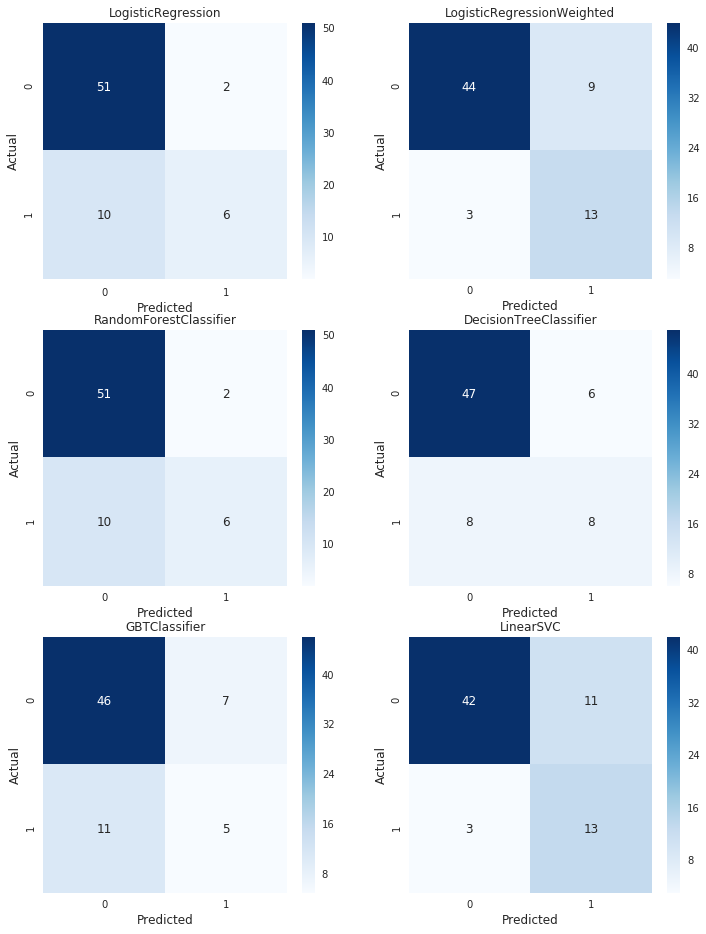

In [148]:
plt.subplots(figsize=(12,16))
plt.subplot(3, 2, 1)
ax = draw_confussion_matrix(predictions['LogisticRegression'], 'LogisticRegression')
plt.subplot(3, 2, 2)
ax = draw_confussion_matrix(predictions['LogisticRegressionWeighted'], 'LogisticRegressionWeighted')
plt.subplot(3, 2, 3)
ax = draw_confussion_matrix(predictions['RandomForestClassifier'], 'RandomForestClassifier')
plt.subplot(3, 2, 4)
ax = draw_confussion_matrix(predictions['DecisionTreeClassifier'], 'DecisionTreeClassifier')
plt.subplot(3, 2, 5)
ax = draw_confussion_matrix(predictions['GBTClassifier'], 'GBTClassifier')
plt.subplot(3, 2, 6)
ax = draw_confussion_matrix(predictions['LinearSVC'], 'LinearSVC');

This is the feature importance obtained in the Random Forest model:

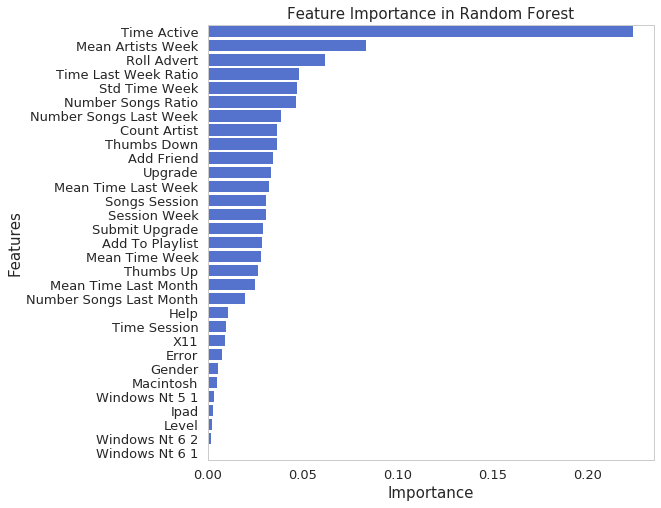

In [149]:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("talk")
# feature importance for Random Forest Classifier
coef = list(fitted_models['RandomForestClassifier'].bestModel.stages[-1].featureImportances.toArray())
df_feat = pd.DataFrame({'features': all_features, 
                        'coefficients': coef}).sort_values(by=['coefficients'], ascending = False)

df_feat.features = df_feat.features.str.replace('_', ' ').str.title()
df_feat = df_feat[df_feat.coefficients > 0]

plt.figure(figsize=(8,8))
ax = sns.barplot(x='coefficients', 
                 y='features', 
                 data=df_feat, 
                 color="royalblue")

ax.set_title("Feature Importance in Random Forest", fontsize=15)
ax.set_xlabel('Importance', fontsize=15)
ax.set_ylabel('Features', fontsize=15);


This is the feature importance obtained in the Decision Tree Classifier:

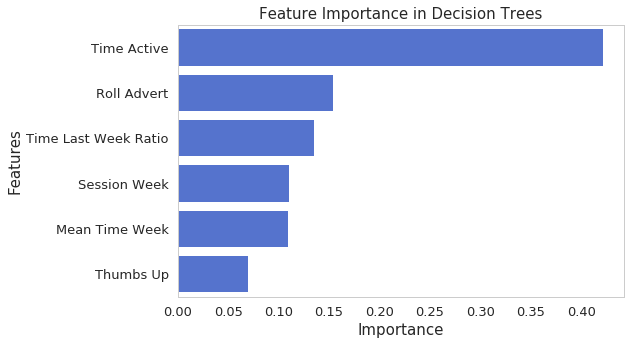

In [150]:
# feature importance  for Decision Tree Classifier
coef = list(fitted_models['DecisionTreeClassifier'].bestModel.stages[-1].featureImportances.toArray())
df_feat = pd.DataFrame({'features': all_features, 
                        'coefficients': coef}).sort_values(by=['coefficients'], ascending = False)

df_feat.features = df_feat.features.str.replace('_', ' ').str.title()
df_feat = df_feat[df_feat.coefficients > 0]

plt.figure(figsize=(8,5))
ax = sns.barplot(x='coefficients', 
                 y='features', 
                 data=df_feat, 
                 color="royalblue");

ax.set_title("Feature Importance in Decision Trees", fontsize=15)
ax.set_xlabel('Importance', fontsize=15)
ax.set_ylabel('Features', fontsize=15);


This es the tree defined in this model:

In [151]:
string = fitted_models['DecisionTreeClassifier'].bestModel.stages[-1].toDebugString
for i, feat in enumerate(all_features):
    string = string.replace('feature ' + str(i) + ' ', feat + ' ')
print(string)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_6df7672f4134) of depth 3 with 13 nodes
  If (time_active <= -0.6197357107730448)
   If (Roll_Advert <= -0.9286574663795464)
    If (mean_time_week <= 0.7569785923253749)
     Predict: 0.0
    Else (mean_time_week > 0.7569785923253749)
     Predict: 1.0
   Else (Roll_Advert > -0.9286574663795464)
    If (time_last_week_ratio <= -0.5307551227335654)
     Predict: 0.0
    Else (time_last_week_ratio > -0.5307551227335654)
     Predict: 1.0
  Else (time_active > -0.6197357107730448)
   If (Thumbs_Up <= -0.9796966205602818)
    If (session_week <= -0.46990735166458075)
     Predict: 0.0
    Else (session_week > -0.46990735166458075)
     Predict: 1.0
   Else (Thumbs_Up > -0.9796966205602818)
    Predict: 0.0



This is the feature importance obtained in the GBT Classifier:

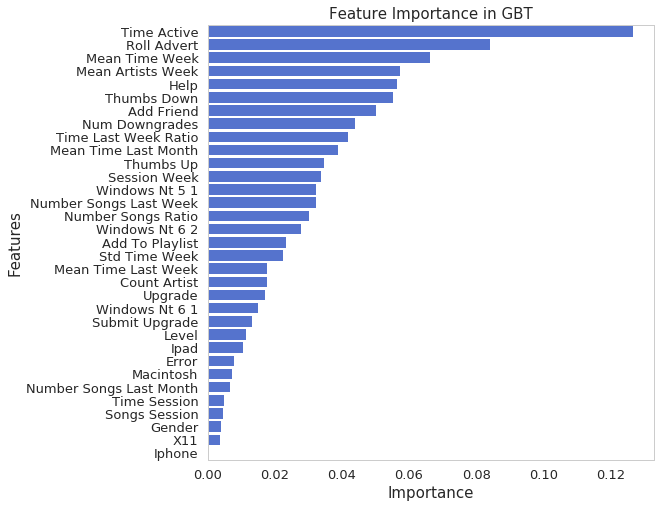

In [152]:
# feature importance  for GBT Classifier
coef = list(fitted_models['GBTClassifier'].bestModel.stages[-1].featureImportances.toArray())
df_feat = pd.DataFrame({'features': all_features, 
                        'coefficients': coef}).sort_values(by=['coefficients'], ascending = False)

df_feat.features = df_feat.features.str.replace('_', ' ').str.title()
df_feat = df_feat[df_feat.coefficients > 0]

plt.figure(figsize=(8,8))
ax = sns.barplot(x='coefficients', 
                 y='features', 
                 data=df_feat, 
                 color="royalblue")

ax.set_title("Feature Importance in GBT", fontsize=15)
ax.set_xlabel('Importance', fontsize=15)
ax.set_ylabel('Features', fontsize=15);


This is the code we have used to decide which is the best number of features to apply to the PCA transformation. We have executed the LogisticRegressionWeighted model with different number of k and draw the f1 values obtained in the validations test in a graph. This method needs to fit the Logistic Regression Model 25 times, so it can take a long time.

In [153]:
# initialize variables to save the results for each k value
f1 = []
f1_0 = []
f1_1 = []

# a sub dictionary with the parameters of the Weighted Logistic Regression Model
sub_models_dict = {'modelName': [estimator_name_list[1]],
                   'paramGrids': [paramGrid_list[1]], 
                   'estimators': [estimator_list[1]]}

# for each value of k (number of features)
for k in range(1,25,1):
    # get a a dataframe with the lave, a vector with the features and a vector with k 
    # features after applying PCA
    df_vector = get_vectorized_df(df_features, numerical_features, categorical_features, k)
    # divide this dataframe into validation and train set
    train_set, validation_set = get_train_validation_sets(df_vector, seed = 42, prop = 0.7)
    # add a column with the weight of the class to the train set
    train_set = add_weight_column(train_set)
    train_set = train_set.cache()
    # fit the model LogisticRegressionWeighted
    fitted_models = fit_models (sub_models_dict, train_set, metric = 'f1', print_out = False)
    # make predictos and obtain f1_values
    predictions, f1_results = predict_validation_set(fitted_models, validation_set)
    
    # save the f1 values obtained into lists for each k.
    # we save the total f1, and the f1 for the class 0 and  1
    f1.append(f1_results[f1_results.Model == 
                                      'LogisticRegressionWeighted'].F1_Total[0])
    f1_0.append(f1_results[f1_results.Model == 
                                      'LogisticRegressionWeighted'].F1_0[0])
    f1_1.append(f1_results[f1_results.Model == 
                                      'LogisticRegressionWeighted'].F1_1[0])

# save the final result in a dataframe
df_pca_evaluation = pd.DataFrame(data={'k': range(1,25,1),
                                       'f1': f1,
                                       'f1_0': f1_0,
                                       'f1_1': f1_1})
    


In [154]:
df_pca_evaluation.sort_values(by=['f1'], ascending = False).head()

,k,f1,f1_0,f1_1
17,18,0.834600,0.907216,0.896552
15,16,0.832339,0.918367,0.857143
16,17,0.821842,0.895833,0.896552
14,15,0.807033,0.895833,0.857143
12,13,0.794433,0.884211,0.857143


This is the graph with the results:

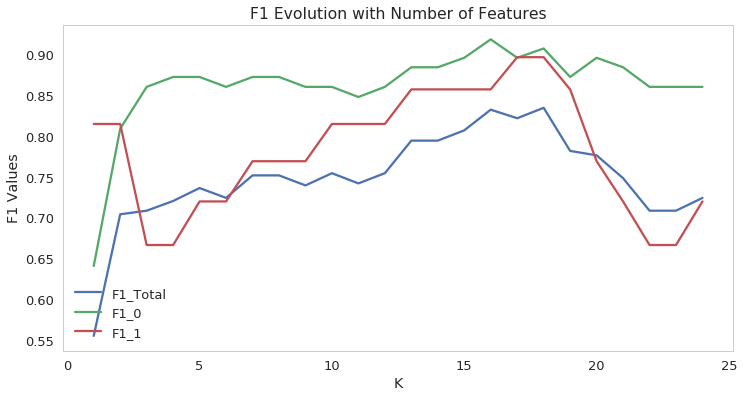

In [155]:
plt.figure(figsize=(12,6))
plt.plot(df_pca_evaluation.k, df_pca_evaluation.f1, label="F1_Total")
plt.plot(df_pca_evaluation.k, df_pca_evaluation.f1_0, label="F1_0")
plt.plot(df_pca_evaluation.k, df_pca_evaluation.f1_1, label="F1_1")
plt.xlabel('K')
plt.ylabel('F1 Values')
plt.title('F1 Evolution with Number of Features')
plt.legend(loc=3);

The best result for all the values of F1 is obtained when K=18, but if we want to test with other data it seems that a value between 13 and 18 can be a good option.

<a id='conclusions'></a>
## Conclusions

When we start the modeling we saw that we have better results applying Logistic Regression, so we focus our attention into improve it. 
We also have tried to detect as many cancellations or churned users as possible, even if this suppose to increase the number of false positives. We think that is preferable to fail some 0 values that to miss some 1 value in the churn. Anyway, we don't know if the customers that has not cancelled their account and that they have been missclassified as they did it, are close to do it or not. They may cancel the service the next weeks. Because of this we have decided to include the weight of each class in the parameters of the models that admit it (Logistic Regression and Linear SVC). The improvement in the resulst was remarkable.

As a conclusion this are the values for `F1` and `Accuracy` obtained for all the models we have tested. We have extracted the general performance and the values for the class 0 and 1 because we are especially interested in knowing the scores for the churn value 1:

     
| Model                      | F1_Total | F1_0     | F1_1     | Accuracy_Total | Accuracy_0 | Accuracy_1 |
|----------------------------|----------|----------|----------|----------------|------------|------------|
| WeightedLogisticRegression | 0.834600 | 0.907216 | 0.896552 | 0.826087       | 0.830189   | 0.8125     |
| WeightedLinearSVC          | 0.821842 | 0.895833 | 0.896552 | 0.811594       | 0.811321   | 0.8125     |
| LogisticRegression         | 0.803204 | 0.980769 | 0.545455 | 0.826087       | 0.962264   | 0.3750     |
| RandomForestClassifier     | 0.791053 | 0.970874 | 0.545455 | 0.811594       | 0.943396   | 0.3750     |
| DecisionTreeClassifier     | 0.804442 | 0.950495 | 0.666667 | 0.811594       | 0.905660   | 0.5000     |
| GBTClassifier              | 0.739130 | 0.907216 | 0.608696 | 0.739130       | 0.830189   | 0.4375     |


There are two models very close to each other:

   * Weighted Logistic Regression 
   * Weighted Linear SVC 
     
In this dataset we should choose the `Weighted Logistic Regression` but this decision can change with a bigger dataset.

We also have extracted the principal componentes with PCA to avoid collinearity between features. Analyzing the performance on the `Logistic Regression` model we have found that for this dataset we should select 18 final features, but this can also change with other dataset. Anyway, it seems that the correct value should be a number between 13 and 18. They are good options to try.

Regarding the other models, it is also remarkable the behaviour of the `Decision Tree` model because with very simple algorithm, using few features, it was able to detected half of the cancelled users and it has made a limited number of false positives misatakes. It can be also a good option if you want a fast method and you are not so concerned about the accuracy.

Finally, we have obtained a more poorer result in the `GBT Classifier` and in `Random Forest`, but this one can be also useful to understand which features are influent in the classification:  

    - number of days active
    - standard deviation of time per week 
    - to click in tumbs up 
    - the numer of songs in the last wee
    - the ratio between the time per day in the las week and the last month 
    - the mean time per day in the last month
    - etc

To improve the model we can try to explore other features, for example, we don't have used information about the location. I thought that it could be better don't use it in this dataset, because probably we don't have users enough for all the locations. It can occur that a specific place haven't had any cancellations, but not because the probability is lower, but just because we don't have enough users in this place. This could have made the f1 results better in this dataset, but surely they won't be so good en a more generalized dataset.

A blog with the summary of this work was posted in this [link](https://medium.com/@jesus.mira74/sparkify-analysis-of-churn-predictions-using-pyspark-f6a6a12530ae).
